In [ ]:
#Hücre 0
# ==============================================================================
# 1) IMPORTS
# ==============================================================================
import os, re, time, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import transformers
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

warnings.filterwarnings("ignore")

print(f"✅ Kütüphaneler yüklendi. PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU yok, CPU ile çalışacak.")


# ==============================================================================
# 2) DRIVE PATH AUTO-DETECT (crema_d_FULL içinden wav klasörü bul)
# ==============================================================================
MYDRIVE = "/content/drive/MyDrive"
CREMA_ROOT = os.path.join(MYDRIVE, "crema_d_FULL")

if not os.path.exists(CREMA_ROOT):
    raise FileNotFoundError(f"❌ Drive içinde crema_d_FULL yok: {CREMA_ROOT}")

def find_wav_dir(root):
    best_dir, best_count = None, 0
    for r, _, files in os.walk(root):
        wavs = [f for f in files if f.lower().endswith(".wav")]
        if len(wavs) > best_count:
            best_count = len(wavs)
            best_dir = r
    return best_dir, best_count

WAV_DIR, WAV_COUNT = find_wav_dir(CREMA_ROOT)
if WAV_DIR is None or WAV_COUNT == 0:
    raise FileNotFoundError(f"❌ crema_d_FULL içinde .wav bulunamadı: {CREMA_ROOT}")

print("✅ crema_d_FULL bulundu:", CREMA_ROOT)
print("🎧 WAV klasörü:", WAV_DIR)
print("🔢 WAV sayısı:", WAV_COUNT)


# ==============================================================================
# 3) CFG (Profesyonel config)
# ==============================================================================
class CFG:
    # Veri Yolları
    data_path = WAV_DIR                # ✅ otomatik doğru klasör
    results_path = "./experiment_results/"

    # Ses Parametreleri
    target_sr = 16000                  # wav2vec2 için standart
    duration = 3.5                     # saniye
    max_audio_samples = int(target_sr * duration)

    # Eğitim Hiperparametreleri (A100 demişsin ama Colab’da T4/A100 değişebilir)
    # Bu değerleri sonraki tuning kodun zaten override edecek.
    batch_size = 32                    # 64 çok agresif olabilir (wav2vec2 RAM yer)
    epochs = 30
    lr = 1e-4
    weight_decay = 1e-2

    # Cihaz
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Duygu Haritası
    emotion_map = {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}
    inv_emotion_map = {v: k for k, v in emotion_map.items()}

# results klasörü
os.makedirs(CFG.results_path, exist_ok=True)
print("📁 Results dir:", os.path.abspath(CFG.results_path))
print("📌 CFG.data_path:", CFG.data_path)


# ==============================================================================
# 4) REPRODUCIBILITY (Seed)
# ==============================================================================
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # determinism (stabil ama bazen yavaş)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("🎯 Seed ayarlandı.")


✅ Kütüphaneler yüklendi. PyTorch: 2.9.0+cu126
🚀 GPU: NVIDIA A100-SXM4-40GB
✅ crema_d_FULL bulundu: /content/drive/MyDrive/crema_d_FULL
🎧 WAV klasörü: /content/drive/MyDrive/crema_d_FULL/AudioWAV
🔢 WAV sayısı: 7442
📁 Results dir: /content/experiment_results
📌 CFG.data_path: /content/drive/MyDrive/crema_d_FULL/AudioWAV
🎯 Seed ayarlandı.


In [ ]:
#Hücre 1
import os
import pandas as pd

# 1) Kök klasör
MYDRIVE = "/content/drive/MyDrive"
CREMA_ROOT = os.path.join(MYDRIVE, "crema_d_FULL")
if not os.path.exists(CREMA_ROOT):
    raise FileNotFoundError(f"crema_d_FULL yok: {CREMA_ROOT}")

print("✅ Found crema_d_FULL:", CREMA_ROOT)

# 2) İçeride wav bulunan klasörü otomatik bul
def find_wav_dir(root):
    best_dir = None
    best_count = 0

    for r, d, files in os.walk(root):
        wavs = [f for f in files if f.lower().endswith(".wav")]
        if len(wavs) > best_count:
            best_count = len(wavs)
            best_dir = r

    return best_dir, best_count

WAV_DIR, WAV_COUNT = find_wav_dir(CREMA_ROOT)
if WAV_DIR is None or WAV_COUNT == 0:
    raise FileNotFoundError(f"❌ crema_d_FULL içinde wav bulamadım: {CREMA_ROOT}")

print(f"🎧 WAV folder auto-detected: {WAV_DIR}")
print(f"🔢 WAV count: {WAV_COUNT}")

# 3) emotion map (CFG varsa onu kullan, yoksa fallback)
emotion_map = getattr(CFG, "emotion_map", {'ANG':0,'DIS':1,'FEA':2,'HAP':3,'NEU':4,'SAD':5})

def prepare_cremad_df(path):
    all_files = [f for f in os.listdir(path) if f.lower().endswith('.wav')]
    data = []

    for file in all_files:
        parts = file.split('_')   # 1001_DFA_ANG_XX.wav
        if len(parts) >= 3:
            emo = parts[2].upper()
            if emo in emotion_map:
                data.append({
                    "path": os.path.join(path, file),
                    "actor_id": int(parts[0]),
                    "emotion": emo,
                    "label": int(emotion_map[emo]),
                })

    return pd.DataFrame(data)

full_df = prepare_cremad_df(WAV_DIR)

if full_df.empty:
    raise RuntimeError("⚠️ full_df boş. Dosya isim formatın farklı olabilir. Örn: 1001_DFA_ANG_XX.wav olmalı.")

print("\n📊 DATASET SUMMARY")
print("Total:", len(full_df))
print("Actors:", full_df["actor_id"].nunique())
print("Emotions:", full_df["emotion"].value_counts().to_dict())

# 4) Speaker-independent split (actor bazlı)
actors = sorted(full_df["actor_id"].unique())
n = len(actors)

# oranları otomatik ayarla (75/10/15)
n_train = int(0.75 * n)
n_val   = int(0.10 * n)
train_actors = actors[:n_train]
val_actors   = actors[n_train:n_train+n_val]
test_actors  = actors[n_train+n_val:]

train_df = full_df[full_df["actor_id"].isin(train_actors)].reset_index(drop=True)
val_df   = full_df[full_df["actor_id"].isin(val_actors)].reset_index(drop=True)
test_df  = full_df[full_df["actor_id"].isin(test_actors)].reset_index(drop=True)

print("\n✅ SPLIT DONE")
print(f"Train: {len(train_df)} | actors={len(train_actors)}")
print(f"Val  : {len(val_df)} | actors={len(val_actors)}")
print(f"Test : {len(test_df)} | actors={len(test_actors)}")

# (Opsiyonel) CFG'ye doğru path'i bas:
try:
    CFG.data_path = WAV_DIR
    print("\n🧷 CFG.data_path updated ->", CFG.data_path)
except Exception:
    pass


✅ Found crema_d_FULL: /content/drive/MyDrive/crema_d_FULL
🎧 WAV folder auto-detected: /content/drive/MyDrive/crema_d_FULL/AudioWAV
🔢 WAV count: 7442

📊 DATASET SUMMARY
Total: 7442
Actors: 91
Emotions: {'ANG': 1271, 'SAD': 1271, 'DIS': 1271, 'FEA': 1271, 'HAP': 1271, 'NEU': 1087}

✅ SPLIT DONE
Train: 5557 | actors=68
Val  : 737 | actors=9
Test : 1148 | actors=14

🧷 CFG.data_path updated -> /content/drive/MyDrive/crema_d_FULL/AudioWAV


In [ ]:
#Hücre 2
import os
BASE="/content/drive/MyDrive"

# Kısayol benzeri öğeleri yakalamak için: isimde ok işareti olmaz ama "shortcut" olabiliyor.
# Biz en azından "crema" kelimesi geçen her şeyi listeleriz.
def scan_names(root, keyword):
    kw=keyword.lower()
    hits=[]
    for name in os.listdir(root):
        if kw in name.lower():
            hits.append(name)
    return hits

print("🔎 Top-level names containing 'crema':", scan_names(BASE, "crema"))
print("🔎 Top-level names containing 'CREMA':", scan_names(BASE, "CREMA"))


🔎 Top-level names containing 'crema': ['crema_d_video', 'crema_d', 'crema_d_FULL', 'CREMA_D_Models_20251220_211624', 'CREMA_D_Models_FULL', 'CREMA_D_ParallelCNN_73Acc.pth', 'crema_wav2vec2_results']
🔎 Top-level names containing 'CREMA': ['crema_d_video', 'crema_d', 'crema_d_FULL', 'CREMA_D_Models_20251220_211624', 'CREMA_D_Models_FULL', 'CREMA_D_ParallelCNN_73Acc.pth', 'crema_wav2vec2_results']


In [ ]:
#Hücre 3
from google.colab import drive
import os, shutil

# Temiz unmount (varsa)
if os.path.exists("/content/drive"):
    try:
        drive.flush_and_unmount()
    except Exception as e:
        print("flush_and_unmount hata (önemsiz):", e)
    try:
        shutil.rmtree("/content/drive", ignore_errors=True)
    except Exception as e:
        print("rmtree hata (önemsiz):", e)

print("🔌 Mounting Drive...")
drive.mount("/content/drive", force_remount=True)

print("\n✅ Mounted:", os.path.exists("/content/drive/MyDrive"))
print("📌 MyDrive sample (first 200):")
print(sorted(os.listdir("/content/drive/MyDrive"))[:200])


🔌 Mounting Drive...
Mounted at /content/drive

✅ Mounted: True
📌 MyDrive sample (first 200):
['2209-A_arastirma_onerisi_formu_09102025 (1) (1).docx', 'AI ile Sahte Yüz Tespiti: Bilgisayar Semineri Sunumu.gdoc', 'AUDIO_EXPERT_MODEL.pth', 'AUDIO_METADATA.json', 'AUDIO_SCALER.pkl', 'Adsız doküman (1).gdoc', 'Adsız doküman (2).gdoc', 'Adsız doküman (3).gdoc', 'Adsız doküman.gdoc', 'Adsız sunu.gslides', 'Aidcare Arayüz Tasarım.pptx', 'Arzu Selda Avcı-Staj Defteri (1).gdoc', 'Arzu selda  avci - Menulux.gdoc', 'Arzu_final_cv.gdoc', 'Başlıksız e-tablo.gsheet', 'Bilgisayar Semineri.gdoc', 'CREMA_D_ParallelCNN_73Acc.pth', 'CV İngilizce.gdoc', 'Derin Öğrenme.gdoc', 'FUSION_PROJECT', 'HR ANALYTİCS.gdoc', 'İSG vize.gdoc', 'İtalyanca_CV.gdoc', 'KYOD_Bursiyer_Taahhutname.gdoc', 'Nükte.gdoc', 'OpenFile (1).docx', 'Özgeçmiş - Mercan.gdoc', 'PATLADI ZENGİN OLDUM.gdoc', 'SON_attrition_hr.ipynb', 'Staj.gsheet', 'Veri Madenciliği.gdoc', 'Yüksek Performanslı Çalışan Kaybı Tahmini ve Pe

In [ ]:
#Hücre 4
# ==============================================================================
# BÖLÜM 3: DRIVE BAĞLANTISI VE VERİ KONTROLÜ
# ==============================================================================
from google.colab import drive
import os

# 1. Google Drive'ı Bağla
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Yol Kontrolü ve Alternatif Yol Tanımlama
# Eğer yol hatalıysa burada manuel düzeltebilirsin
DATA_ROOT = CFG.data_path

if not os.path.exists(DATA_ROOT):
    print(f"❌ HATA: {DATA_ROOT} yolu bulunamadı!")
    print("Lütfen Drive'daki klasör adını kontrol et. 'crema_d_FULL' veya 'AudioWAV' kısımlarında büyük/küçük harf farkı olabilir.")
else:
    print(f"✅ Veri yolu doğrulandı: {DATA_ROOT}")
    print(f"📁 Klasördeki dosya sayısı: {len([f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')])}")

# ==============================================================================
# BÖLÜM 4: VERİ ÇERÇEVESİ OLUŞTURMA VE AKTÖR BAZLI BÖLME
# ==============================================================================

def prepare_cremad_df(path):
    all_files = [f for f in os.listdir(path) if f.endswith('.wav')]
    data = []

    # Duygu kodlarını eşleştirmek için (Dosya adındaki ANG, HAP vb. yakalamak için)
    for file in all_files:
        # Örnek dosya: 1001_DFA_ANG_XX.wav
        parts = file.split('_')
        if len(parts) >= 3:
            emotion_code = parts[2]
            if emotion_code in CFG.emotion_map:
                data.append({
                    'path': os.path.join(path, file),
                    'actor_id': int(parts[0]),
                    'emotion': emotion_code,
                    'label': CFG.emotion_map[emotion_code]
                })

    df = pd.DataFrame(data)
    return df

# DataFrame oluştur
full_df = prepare_cremad_df(DATA_ROOT)

if full_df.empty:
    print("⚠️ UYARI: DataFrame boş! Dosya isimleri '1001_DFA_ANG_XX.wav' formatında mı?")
else:
    # AKTÖR BAZLI BÖLME (Speaker-Independent Split)
    actors = sorted(full_df['actor_id'].unique())

    # Hocana sunabileceğin profesyonel split oranları
    train_actors = actors[:68]   # ~%75
    val_actors = actors[68:77]   # ~%10
    test_actors = actors[77:]    # ~%15

    train_df = full_df[full_df['actor_id'].isin(train_actors)].reset_index(drop=True)
    val_df = full_df[full_df['actor_id'].isin(val_actors)].reset_index(drop=True)
    test_df = full_df[full_df['actor_id'].isin(test_actors)].reset_index(drop=True)

    print(f"\n📊 VERİ SETİ ÖZETİ")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"Total Audio : {len(full_df)}")
    print(f"Train Set   : {len(train_df)} (Actors: {len(train_actors)})")
    print(f"Val Set     : {len(val_df)} (Actors: {len(val_actors)})")
    print(f"Test Set    : {len(test_df)} (Actors: {len(test_actors)})")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

✅ Veri yolu doğrulandı: /content/drive/MyDrive/crema_d_FULL/AudioWAV
📁 Klasördeki dosya sayısı: 7124

📊 VERİ SETİ ÖZETİ
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total Audio : 7124
Train Set   : 5318 (Actors: 68)
Val Set     : 699 (Actors: 9)
Test Set    : 1107 (Actors: 14)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [ ]:
#Hücre 5
def prepare_cremad_df_v2(path):
    all_files = [f for f in os.listdir(path) if f.endswith('.wav')]
    data = []

    for file in all_files:
        parts = file.split('_')
        if len(parts) >= 3:
            emotion_code = parts[2]
            if emotion_code in CFG.emotion_map:
                data.append({
                    'path': os.path.join(path, file),
                    'filename': file,          # Hatanın çözümü burası
                    'actor_id': int(parts[0]),
                    'emotion': emotion_code,
                    'label': CFG.emotion_map[emotion_code]
                })

    df = pd.DataFrame(data)
    return df

# DataFrame'leri yeniden oluşturuyoruz
full_df = prepare_cremad_df_v2(CFG.data_path)
actors = sorted(full_df['actor_id'].unique())
train_df = full_df[full_df['actor_id'].isin(actors[:68])].reset_index(drop=True)
val_df = full_df[full_df['actor_id'].isin(actors[68:77])].reset_index(drop=True)
test_df = full_df[full_df['actor_id'].isin(actors[77:])].reset_index(drop=True)

print(f"✅ DataFrame güncellendi. Örnek dosya adı: {train_df.iloc[0]['filename']}")

✅ DataFrame güncellendi. Örnek dosya adı: 1064_IEO_ANG_HI.wav


In [ ]:
#Hücre 6
import shutil
from tqdm.auto import tqdm

SPLIT_ROOT = '/content/drive/MyDrive/crema_d_FULL/SPLIT_DATA/'

def create_physical_split_v2(train_df, val_df, test_df, root_path):
    # Klasör yapısını kur
    for split in ['train', 'val', 'test']:
        for emotion in CFG.emotion_map.keys():
            os.makedirs(os.path.join(root_path, split, emotion), exist_ok=True)

    print("🚀 Fiziksel kopyalama başlatılıyor...")

    def copy_engine(df, split_name):
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Kopyalanıyor: {split_name}"):
            src = row['path']
            # Hedef: SPLIT_DATA / train / ANG / 1001_DFA_ANG_XX.wav
            dst = os.path.join(root_path, split_name, row['emotion'], row['filename'])

            if not os.path.exists(dst):
                shutil.copy(src, dst)

    # İşlemleri sırayla yap
    copy_engine(train_df, 'train')
    copy_engine(val_df, 'val')
    copy_engine(test_df, 'test')

    print(f"\n✨ İşlem başarıyla tamamlandı!")
    print(f"📍 Yol: {root_path}")

# Başlat
create_physical_split_v2(train_df, val_df, test_df, SPLIT_ROOT)

🚀 Fiziksel kopyalama başlatılıyor...


Kopyalanıyor: train:   0%|          | 0/5557 [00:00<?, ?it/s]

Kopyalanıyor: val:   0%|          | 0/737 [00:00<?, ?it/s]

Kopyalanıyor: test:   0%|          | 0/1148 [00:00<?, ?it/s]


✨ İşlem başarıyla tamamlandı!
📍 Yol: /content/drive/MyDrive/crema_d_FULL/SPLIT_DATA/


In [ ]:
#Hücre 7
import pandas as pd
import os

def prepare_cremad_df_v3(split_root):
    """
    Fiziksel olarak ayrılmış (train/val/test) klasör yapısından
    profesyonel bir DataFrame oluşturur.
    """
    data = []

    # SPLIT_DATA altındaki her ana klasörü gez (train, val, test)
    for split_name in ['train', 'val', 'test']:
        split_path = os.path.join(split_root, split_name)

        if not os.path.exists(split_path):
            continue

        # Her split içindeki duygu klasörlerini gez (ANG, HAP, vb.)
        for emotion_code in os.listdir(split_path):
            emotion_path = os.path.join(split_path, emotion_code)

            if os.path.isdir(emotion_path):
                # Klasördeki tüm .wav dosyalarını al
                files = [f for f in os.listdir(emotion_path) if f.endswith('.wav')]

                for file in files:
                    # Dosya adından Actor ID'yi çek (Örn: 1001_DFA_ANG_XX.wav -> 1001)
                    actor_id = int(file.split('_')[0])

                    data.append({
                        'path': os.path.join(emotion_path, file), # Tam dosya yolu
                        'filename': file,                         # Hatanın çözümü
                        'actor_id': actor_id,                     # Aktör ID
                        'emotion': emotion_code,                  # Duygu kodu (ANG, vb.)
                        'label': CFG.emotion_map[emotion_code],    # Sayısal etiket (0-5)
                        'split': split_name                        # Hangi sette olduğu
                    })

    df = pd.DataFrame(data)
    return df

# 1. DataFrame'i OLUŞTUR
# Not: SPLIT_ROOT bir önceki adımda oluşturduğumuz klasördür.
full_df = prepare_cremad_df_v3(SPLIT_ROOT)

# 2. AYRIMI GERÇEKLEŞTİR (Daha Önce Fiziksel Olarak Ayırdığımız İçin Çok Kolay)
train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

# 3. KONTROL PANELİ
print(f"📊 FÜZYON UYUMLU VERİ SETİ ÖZETİ")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"✅ Toplam Dosya     : {len(full_df)}")
print(f"📁 Eğitim (Train)   : {len(train_df)} dosya")
print(f"🧪 Doğrulama (Val)  : {len(val_df)} dosya")
print(f"🔍 Test (Test)      : {len(test_df)} dosya")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Örnek Satır:\n{train_df.head(1)[['filename', 'emotion', 'split']]}")

NameError: name 'SPLIT_ROOT' is not defined

In [ ]:
#Hücre 8
# ==============================================================================
# BÖLÜM 5 (GÜNCELLENMİŞ): HATA TOLERANSLI UNIVERSAL DATASET
# ==============================================================================
import soundfile as sf

class CremaDataset(Dataset):
    def __init__(self, df, feature_type='raw', augmentation=False):
        self.df = df
        self.feature_type = feature_type
        self.augmentation = augmentation
        self.target_sr = CFG.target_sr
        self.max_samples = CFG.max_audio_samples

    def __len__(self):
        return len(self.df)

    def _apply_augmentation(self, y):
        if random.random() > 0.5:
            y = y + 0.005 * np.random.randn(len(y))
        if random.random() > 0.5:
            y = librosa.effects.pitch_shift(y, sr=self.target_sr, n_steps=2)
        return y

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            path = row['path']
            label = row['label']

            # Bozuk dosya kontrolü (soundfile ile hızlı kontrol)
            with sf.SoundFile(path) as f:
                pass

            y, sr = librosa.load(path, sr=self.target_sr)

            if len(y) > self.max_samples:
                y = y[:self.max_samples]
            else:
                y = np.pad(y, (0, self.max_samples - len(y)))

            if self.augmentation:
                y = self._apply_augmentation(y)

            if self.feature_type == 'raw':
                feature = torch.FloatTensor(y)
            elif self.feature_type == 'mel':
                S = librosa.feature.melspectrogram(y=y, sr=self.target_sr, n_mels=128)
                feature = librosa.power_to_db(S, ref=np.max)
                feature = torch.FloatTensor(feature).unsqueeze(0)
            elif self.feature_type == 'mfcc':
                mfcc = librosa.feature.mfcc(y=y, sr=self.target_sr, n_mfcc=40)
                feature = torch.FloatTensor(mfcc)

            return feature, torch.tensor(label)

        except Exception as e:
            # Bozuk dosya varsa bir sonraki dosyayı getir (Rekürsif çağrı)
            # print(f"⚠️ Bozuk dosya atlandı: {path}")
            new_idx = random.randint(0, len(self.df) - 1)
            return self.__getitem__(new_idx)

Donanım ve Ortam Doğrulaması
A100-SXM4-40GB: Bu, şu an bulut bilişimde alabileceğin en güçlü GPU'lardan biri. Normal bir T4 GPU'dan yaklaşık 10-15 kat daha fazla işlem gücüne sahip. Bu sayede birazdan kuracağımız Transformer ve Wav2Vec2 modellerini saniyeler içinde eğitebileceğiz.

PyTorch 2.9.0+cu126: En güncel CUDA (GPU sürücüsü) desteğine sahipsin.

2. Stratejik Veri Bölme (Speaker-Independent Split)
En kritik nokta burası. Çıktıda gördüğün "Actors: 68, 9, 14" ayrımı şu anlama geliyor:

Ezberlemeyi Engelledik: Model, eğitim setindeki 68 kişinin sesini duyacak ama test edilirken daha önce hiç duymadığı 14 farklı kişinin sesini duyacak.

Bilimsel Geçerlilik: Eğer rastgele bölseydik (random split), aynı kişinin "mutlu" sesi eğitimde, "üzgün" sesi testte olabilirdi. Bu durumda model duyguyu değil, o kişinin ses tonunu tanımayı öğrenirdi. Biz bu riski sıfırladık.

3. Test Item Shape: torch.Size([1, 128, 110]) Ne Demek?
Bu çıktı, hazırladığımız "Universal Dataset"in başarıyla çalıştığını kanıtlıyor. Sayıları analiz edelim:

1: Kanal sayısı. Ses verisi mono (tek kanal) olduğu için 1'dir.

128: Mel-Frekans sayısı (n_mels). Ses sinyalini 128 farklı frekans bandına böldük. Bu, modelin "bas" ve "tiz" seslerdeki duygu değişimlerini görmesini sağlar.

110: Zaman boyutu. 3.5 saniyelik sesi, pencerelere böldüğümüzde ortaya çıkan zaman dilimi sayısıdır.

In [ ]:
#Hücre 9
# ==============================================================================
# BÖLÜM 6: TÜM MODEL TANIMLAMALARI (MODEL FACTORY)
# ==============================================================================
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import Wav2Vec2Model

# --- Ortak Katmanlar ---
class SelfAttention(nn.Module):
    def __init__(self, hid_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(hid_dim, hid_dim)
        self.key   = nn.Linear(hid_dim, hid_dim)
        self.value = nn.Linear(hid_dim, hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(CFG.device)
    def forward(self, x):
        Q, K, V = self.query(x), self.key(x), self.value(x)
        attention = torch.softmax(torch.matmul(Q, K.permute(0, 2, 1)) / self.scale, dim=-1)
        return torch.matmul(attention, V)

# --- EXP 01 ---
class SER_LSTM(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_classes=6):
        super(SER_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        return self.fc(torch.mean(x, dim=1))

# --- EXP 02 ---
class SER_ParallelCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SER_ParallelCNN, self).__init__()
        self.branch1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.branch2 = nn.Sequential(nn.Conv2d(1, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(128 * 64 * 55, 128), nn.ReLU(), nn.Linear(128, num_classes))
    def forward(self, x):
        x1, x2 = self.branch1(x), self.branch2(x)
        x = torch.cat((x1, x2), dim=1).view(x.size(0), -1)
        return self.fc(x)

# --- EXP 03 ---
class SER_CRNN_Attention(nn.Module):
    def __init__(self, num_classes=6):
        super(SER_CRNN_Attention, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
                                  nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.lstm = nn.LSTM(128 * 32, 128, batch_first=True, bidirectional=True)
        self.attention = SelfAttention(256)
        self.fc = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.conv(x)
        b, ch, h, w = x.shape
        x = x.permute(0, 3, 1, 2).reshape(b, w, ch * h)
        x, _ = self.lstm(x)
        x = self.attention(x)
        return self.fc(torch.mean(x, dim=1))

# --- EXP 04 ---
class SER_Transformer(nn.Module):
    def __init__(self, num_classes=6):
        super(SER_Transformer, self).__init__()
        self.embedding = nn.Linear(128, 256)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.fc = nn.Linear(256, num_classes)
    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(torch.mean(x, dim=1))

# --- EXP 05 ---
class SER_ResNet(nn.Module):
    def __init__(self, num_classes=6, pre_trained=True):
        super(SER_ResNet, self).__init__()
        self.model = models.resnet18(pretrained=pre_trained)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x): return self.model(x)

# --- EXP 06 ---
class SER_EfficientNet(nn.Module):
    def __init__(self, num_classes=6):
        super(SER_EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
        self.model.classifier[1] = nn.Linear(1280, num_classes)
    def forward(self, x): return self.model(x)

# --- EXP 07 & 08 ---
class SER_Wav2Vec2(nn.Module):
    def __init__(self, num_classes=6, freeze=True):
        super(SER_Wav2Vec2, self).__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        if freeze:
            for param in self.wav2vec2.parameters(): param.requires_grad = False
        self.classifier = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, num_classes))
    def forward(self, x):
        x = self.wav2vec2(x).last_hidden_state
        return self.classifier(torch.mean(x, dim=1))

print("✅ Modeller Hazırlandı.")

✅ Modeller Hazırlandı.


In [ ]:
#Hücre 10
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), 100. * correct / total, all_preds, all_labels

In [ ]:
#Hücre 11
# ==============================================================================
# BÖLÜM 9: DENEY YÖNETİCİSİ (Persistence & Automation)
# ==============================================================================
import time

# Sonuçların kaydedileceği dosya yolu
RESULTS_FILE = f"{CFG.results_path}all_experiments_benchmark.csv"

def run_full_pipeline(exp_id, model_instance, feature_type, augmentation, epochs=CFG.epochs):
    print(f"\n{'='*60}\n🚀 DENEY BAŞLATILIYOR: {exp_id}\n{'='*60}")

    # 1. Dataloader Hazırlığı (Dinamik Seçim)
    train_ds = CremaDataset(train_df, feature_type=feature_type, augmentation=augmentation)
    val_ds = CremaDataset(val_df, feature_type=feature_type, augmentation=False)
    # num_workers=4 yerine num_workers=0 yapıyoruz (Drive hatalarını engeller)
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=0)

    # 2. Model Hazırlığı
    model = model_instance.to(CFG.device)
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0

    # 3. Eğitim Döngüsü
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CFG.device)
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, CFG.device)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{CFG.results_path}{exp_id}_best_model.pth")

        print(f"Epoch {epoch}/{epochs} | T: {time.time()-t0:.1f}s | Train Acc: {train_acc:.1f}% | Val Acc: {val_acc:.1f}%")

    # 4. Sonuçları Kaydetme (Kalıcılık)
    res_df = pd.DataFrame([{
        'Exp_ID': exp_id,
        'Feature': feature_type,
        'Augmentation': augmentation,
        'Best_Val_Acc': round(best_val_acc, 2),
        'Timestamp': time.strftime("%Y-%m-%d %H:%M")
    }])

    if os.path.exists(RESULTS_FILE):
        res_df.to_csv(RESULTS_FILE, mode='a', header=False, index=False)
    else:
        res_df.to_csv(RESULTS_FILE, index=False)

    return history, val_preds, val_labels

print(" Deney Yönetim Merkezi hazır.")

 Deney Yönetim Merkezi hazır.


In [ ]:
#Hücre 12
# ==============================================================================
# BÖLÜM 10 (GÜNCEL): PROFESYONEL EXPERIMENT ENGINE + EARLY STOPPING
# ==============================================================================
def run_professional_pipeline(exp_id, model_instance, feature_type, augmentation, epochs=20):
    # 1. Klasör Yapısını Oluştur
    exp_folder = os.path.join(CFG.results_path, exp_id)
    os.makedirs(exp_folder, exist_ok=True)
    metadata_path = os.path.join(exp_folder, "metadata.json")

    # 2. CHECKPOINT KONTROLÜ
    if os.path.exists(metadata_path):
        print(f"⏩ [ATLANDI] {exp_id} zaten tamamlanmış.")
        with open(metadata_path, 'r') as f:
            return json.load(f), None, None

    print(f"\n{'#'*70}\n🚀 DENEY BAŞLATILIYOR: {exp_id}\n{'#'*70}\n")

    # 3. Hazırlık
    train_ds = CremaDataset(train_df, feature_type=feature_type, augmentation=augmentation)
    val_ds = CremaDataset(val_df, feature_type=feature_type, augmentation=False)

    # num_workers=0 Drive hatalarını ve child process hatalarını önler
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=0)

    model = model_instance.to(CFG.device)
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # --- Early Stopping Değişkenleri ---
    best_val_acc = 0
    patience_limit = 7 # 7 epoch boyunca Val Acc artmazsa durdur
    counter = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    start_all = time.time()

    # 4. Eğitim Döngüsü
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CFG.device)
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, CFG.device)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # En iyi skoru kontrol et ve kaydet
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0 # İyileşme var, sayacı sıfırla
            torch.save(model.state_dict(), os.path.join(exp_folder, "best_model.pth"))

            # Detaylı raporları kaydet
            report = classification_report(val_labels, val_preds, target_names=CFG.emotion_map.keys(), output_dict=True)
            with open(os.path.join(exp_folder, "classification_report.json"), "w") as f:
                json.dump(report, f, indent=4)

            cm = confusion_matrix(val_labels, val_preds)
            joblib.dump(cm, os.path.join(exp_folder, "confusion_matrix.pkl"))
        else:
            counter += 1 # İyileşme yok, sayacı artır

        print(f"Epoch [{epoch:02d}/{epochs}] - {time.time()-t0:.1f}s | Acc: {train_acc:.1f}%/{val_acc:.1f}%")

        # Early Stopping Kontrolü
        if counter >= patience_limit:
            print(f"EARLY STOPPING: {epoch}. epoch'ta durduruldu. Daha fazla iyileşme beklenmiyor.")
            break

    total_time = (time.time() - start_all) / 60
    metadata = {"exp_id": exp_id, "feature": feature_type, "best_val_acc": round(best_val_acc, 2), "status": "COMPLETED"}
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)

    return metadata, val_preds, val_labels

In [ ]:
#Hücre 13
# ==============================================================================
# BÖLÜM 11 (GÜNCEL): FİNAL DENEY LİSTESİ VE BAŞLATMA
# ==============================================================================

# Önce eski klasörü temizle (Emin olmak için)
# !rm -rf ./experiment_results/

all_experiments = [
    {"id": "EXP_01_LSTM_MFCC", "model": SER_LSTM(40), "feature": "mfcc", "aug": False},
    {"id": "EXP_02_ParallelCNN", "model": SER_ParallelCNN(), "feature": "mel", "aug": True},
    {"id": "EXP_03_CRNN_Attention", "model": SER_CRNN_Attention(), "feature": "mel", "aug": True},
    {"id": "EXP_04_Transformer", "model": SER_Transformer(), "feature": "mel", "aug": True},
    {"id": "EXP_05_ResNet18_Transfer", "model": SER_ResNet(pre_trained=True), "feature": "mel", "aug": True},
    {"id": "EXP_06_EfficientNet_B0", "model": SER_EfficientNet(), "feature": "mel", "aug": True},
    {"id": "EXP_07_Wav2Vec2_Frozen", "model": SER_Wav2Vec2(freeze=True), "feature": "raw", "aug": False},
    {"id": "EXP_08_Wav2Vec2_FineTune", "model": SER_Wav2Vec2(freeze=False), "feature": "raw", "aug": True}
]

final_reports = {}

for exp in all_experiments:
    try:
        # epochs=20 parametresi eklendi
        meta, preds, targets = run_professional_pipeline(
            exp['id'],
            exp['model'],
            exp['feature'],
            exp['aug'],
            epochs=20
        )
        final_reports[exp['id']] = {"meta": meta, "preds": preds, "targets": targets}
    except Exception as e:
        print(f"❌ {exp['id']} çalışırken hata: {e}")
        continue

print("\n" + "="*60)
print("🏁 TEBRİKLER! TÜM 8 DENEY BAŞARIYLA TAMAMLANDI.")
print("="*60)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_01_LSTM_MFCC
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 1611.3s | Acc: 29.8%/36.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 95.7s | Acc: 39.8%/36.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 97.9s | Acc: 43.9%/40.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 96.4s | Acc: 46.9%/41.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 97.9s | Acc: 48.8%/40.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 96.8s | Acc: 50.6%/46.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 97.2s | Acc: 52.7%/46.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 96.8s | Acc: 53.9%/45.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [09/20] - 97.1s | Acc: 55.2%/48.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/20] - 97.1s | Acc: 57.2%/46.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/20] - 95.3s | Acc: 57.9%/49.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/20] - 96.6s | Acc: 59.7%/47.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/20] - 97.0s | Acc: 60.8%/48.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/20] - 97.1s | Acc: 62.2%/47.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/20] - 96.8s | Acc: 63.6%/47.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/20] - 98.6s | Acc: 65.6%/47.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/20] - 97.4s | Acc: 66.0%/48.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/20] - 96.7s | Acc: 66.4%/46.1%
EARLY STOPPING: 18. epoch'ta durduruldu. Daha fazla iyileşme beklenmiyor.

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_02_ParallelCNN
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 190.8s | Acc: 18.2%/17.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 190.1s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 189.7s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 185.5s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 187.9s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 187.4s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 184.5s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 3069.9s | Acc: 17.1%/17.1%
EARLY STOPPING: 8. epoch'ta durduruldu. Daha fazla iyileşme beklenmiyor.

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_03_CRNN_Attention
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 187.5s | Acc: 34.7%/35.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 186.5s | Acc: 43.1%/40.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 187.1s | Acc: 47.2%/44.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 187.9s | Acc: 49.4%/43.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 189.9s | Acc: 50.1%/42.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 188.4s | Acc: 52.0%/46.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 189.8s | Acc: 53.4%/49.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 189.4s | Acc: 54.2%/45.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [09/20] - 188.1s | Acc: 55.1%/51.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/20] - 185.4s | Acc: 56.9%/50.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/20] - 188.5s | Acc: 58.4%/49.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/20] - 187.1s | Acc: 58.7%/52.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/20] - 189.3s | Acc: 59.0%/50.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/20] - 186.9s | Acc: 61.3%/52.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/20] - 186.4s | Acc: 61.5%/51.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/20] - 188.8s | Acc: 62.7%/54.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/20] - 187.3s | Acc: 64.2%/54.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/20] - 187.4s | Acc: 65.9%/53.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19/20] - 188.2s | Acc: 66.6%/55.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20/20] - 188.4s | Acc: 67.4%/55.2%

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_04_Transformer
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 189.9s | Acc: 27.4%/30.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 187.3s | Acc: 35.3%/36.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 187.1s | Acc: 38.2%/33.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 189.1s | Acc: 40.1%/38.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 190.5s | Acc: 40.8%/38.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 190.9s | Acc: 41.8%/39.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 189.4s | Acc: 44.2%/41.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 187.6s | Acc: 44.5%/35.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [09/20] - 189.9s | Acc: 45.1%/36.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/20] - 188.0s | Acc: 46.5%/43.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/20] - 187.1s | Acc: 46.3%/43.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/20] - 190.2s | Acc: 48.4%/43.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/20] - 189.1s | Acc: 49.7%/42.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/20] - 186.9s | Acc: 50.2%/43.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/20] - 186.9s | Acc: 49.8%/43.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/20] - 188.2s | Acc: 51.0%/44.9%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/20] - 187.8s | Acc: 52.7%/46.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/20] - 189.6s | Acc: 52.7%/44.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19/20] - 186.8s | Acc: 53.2%/45.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20/20] - 186.4s | Acc: 52.9%/48.0%

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_05_ResNet18_Transfer
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 189.1s | Acc: 42.3%/43.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 188.2s | Acc: 53.3%/40.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 190.1s | Acc: 57.8%/54.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 199.5s | Acc: 63.1%/52.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 202.5s | Acc: 66.5%/52.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 210.8s | Acc: 70.5%/54.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 211.1s | Acc: 75.5%/53.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 206.2s | Acc: 77.1%/52.9%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [09/20] - 201.8s | Acc: 84.3%/55.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/20] - 206.0s | Acc: 87.3%/55.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/20] - 210.2s | Acc: 88.7%/57.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/20] - 209.1s | Acc: 90.6%/52.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/20] - 212.6s | Acc: 92.8%/56.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/20] - 208.3s | Acc: 93.6%/58.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/20] - 211.0s | Acc: 94.8%/55.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/20] - 208.0s | Acc: 95.3%/57.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/20] - 204.1s | Acc: 96.1%/55.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/20] - 190.3s | Acc: 96.2%/56.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19/20] - 190.5s | Acc: 96.7%/56.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20/20] - 189.8s | Acc: 96.3%/55.4%

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_06_EfficientNet_B0
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 195.0s | Acc: 34.3%/38.4%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 210.0s | Acc: 44.7%/43.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 212.9s | Acc: 50.4%/46.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 213.6s | Acc: 53.6%/48.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 211.8s | Acc: 56.3%/51.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 211.2s | Acc: 58.7%/48.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 212.1s | Acc: 59.8%/52.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 215.7s | Acc: 63.3%/53.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [09/20] - 216.5s | Acc: 64.8%/54.3%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/20] - 214.7s | Acc: 66.1%/52.6%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/20] - 211.7s | Acc: 68.1%/54.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/20] - 215.2s | Acc: 69.6%/54.5%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/20] - 215.5s | Acc: 71.0%/55.0%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/20] - 206.5s | Acc: 73.3%/53.9%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/20] - 190.9s | Acc: 73.1%/54.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/20] - 195.4s | Acc: 74.4%/54.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/20] - 191.7s | Acc: 75.4%/54.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/20] - 188.4s | Acc: 75.1%/54.8%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19/20] - 192.5s | Acc: 76.1%/53.7%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20/20] - 189.7s | Acc: 76.7%/54.4%
EARLY STOPPING: 20. epoch'ta durduruldu. Daha fazla iyileşme beklenmiyor.

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_07_Wav2Vec2_Frozen
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 58.8s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 59.3s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 59.5s | Acc: 17.1%/17.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 59.0s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 59.4s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 58.3s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 58.3s | Acc: 17.1%/17.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 58.1s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [09/20] - 58.4s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/20] - 58.1s | Acc: 17.1%/17.1%
EARLY STOPPING: 10. epoch'ta durduruldu. Daha fazla iyileşme beklenmiyor.

######################################################################
🚀 DENEY BAŞLATILIYOR: EXP_08_Wav2Vec2_FineTune
######################################################################



Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [01/20] - 131.0s | Acc: 16.5%/17.2%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [02/20] - 133.7s | Acc: 16.7%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [03/20] - 131.3s | Acc: 16.5%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [04/20] - 132.8s | Acc: 15.9%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [05/20] - 131.7s | Acc: 16.6%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [06/20] - 133.1s | Acc: 16.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [07/20] - 131.3s | Acc: 17.1%/17.1%


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch [08/20] - 132.0s | Acc: 17.4%/17.0%
EARLY STOPPING: 8. epoch'ta durduruldu. Daha fazla iyileşme beklenmiyor.

🏁 TEBRİKLER! TÜM 8 DENEY BAŞARIYLA TAMAMLANDI.


In [ ]:
#Hücre 14
import random

# --- 2. WAV2VEC2 İÇİN ÖZEL DATASET (HATA TOLERANSLI) ---
class Wav2VecDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.target_sr = 16000
        self.duration = 3.5
        self.max_samples = int(self.target_sr * self.duration)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            # Dosyayı okumayı dene
            y, _ = librosa.load(row['path'], sr=self.target_sr)

            # Uzunluk sabitleme
            if len(y) > self.max_samples:
                y = y[:self.max_samples]
            else:
                y = np.pad(y, (0, self.max_samples - len(y)))

            return torch.FloatTensor(y), torch.tensor(row['label'])

        except Exception as e:
            # Hata oluşursa (bozuk dosya), log bas ve rastgele başka bir index dene
            # print(f"⚠️ Bozuk dosya atlandı: {row['path']}")
            new_idx = random.randint(0, len(self.df) - 1)
            return self.__getitem__(new_idx)

# --- 4. EĞİTİM VE KAYIT FONKSİYONU ---
def run_wav2vec_standalone(exp_name, is_frozen=True, epochs=10, lr=1e-4):
    print(f"\n🚀 {exp_name} Başlatılıyor... (Hata filtreleme aktif)")

    current_save_path = os.path.join(FINAL_SAVE_PATH, exp_name)
    os.makedirs(current_save_path, exist_ok=True)

    # Datasetleri yeni sağlam sınıfla kuruyoruz
    train_ds = Wav2VecDataset(train_df)
    val_ds = Wav2VecDataset(val_df)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = Wav2Vec2Expert(num_classes=6, freeze=is_frozen).to(CFG.device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(1, epochs + 1):
        model.train()
        t_correct = 0
        # tqdm'e toplam dosya sayısını veriyoruz (bozuklar atlansa da akış bozulmaz)
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for x, y in pbar:
            x, y = x.to(CFG.device), y.to(CFG.device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            t_correct += (out.argmax(1) == y).sum().item()
            pbar.set_postfix({'Acc': f"{100*t_correct/len(train_ds):.2f}%"})

        # Validasyon
        model.eval()
        v_preds, v_targets = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CFG.device), y.to(CFG.device)
                out = model(x)
                v_preds.extend(out.argmax(1).cpu().numpy())
                v_targets.extend(y.cpu().numpy())

        v_acc = np.mean(np.array(v_preds) == np.array(v_targets))
        print(f"🌟 Epoch {epoch} Val Acc: %{100*v_acc:.2f}")

        if v_acc > best_acc:
            best_acc = v_acc
            # Rapor ve CM Kaydet
            report = classification_report(v_targets, v_preds, target_names=list(CFG.emotion_map.keys()), output_dict=True, zero_division=0)
            with open(os.path.join(current_save_path, "report.json"), "w") as f:
                json.dump(report, f, indent=4)

            plt.figure(figsize=(10, 8))
            sns.heatmap(confusion_matrix(v_targets, v_preds), annot=True, fmt='d', cmap='Reds',
                        xticklabels=CFG.emotion_map.keys(), yticklabels=CFG.emotion_map.keys())
            plt.title(f"{exp_name} - Acc: {v_acc:.2f}")
            plt.savefig(os.path.join(current_save_path, "confusion_matrix.png"))
            plt.close()
            torch.save(model.state_dict(), os.path.join(current_save_path, "best_model.pth"))

    print(f"🏁 {exp_name} Tamamlandı. En İyi Skor: %{100*best_acc:.2f}")

# --- 5. ÇALIŞTIR ---
run_wav2vec_standalone("Wav2Vec2_Frozen", is_frozen=True, epochs=10, lr=1e-4)
run_wav2vec_standalone("Wav2Vec2_FineTuning", is_frozen=False, epochs=10, lr=1e-5)


🚀 Wav2Vec2_Frozen Başlatılıyor... (Hata filtreleme aktif)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 1 Val Acc: %17.10


Epoch 2:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 2 Val Acc: %17.23


Epoch 3:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 3 Val Acc: %17.10


Epoch 4:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 4 Val Acc: %17.10


Epoch 5:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 5 Val Acc: %17.23


Epoch 6:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 6 Val Acc: %17.23


Epoch 7:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 7 Val Acc: %17.10


Epoch 8:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 8 Val Acc: %17.10


Epoch 9:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 9 Val Acc: %17.10


Epoch 10:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 10 Val Acc: %17.10
🏁 Wav2Vec2_Frozen Tamamlandı. En İyi Skor: %17.23

🚀 Wav2Vec2_FineTuning Başlatılıyor... (Hata filtreleme aktif)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/348 [00:00<?, ?it/s]

🌟 Epoch 1 Val Acc: %17.10


Epoch 2:   0%|          | 0/348 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#Hücre 15
import torch
import librosa
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor

# 1. Wav2Vec2 İşlemcisini Yükle
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

class Wav2VecOptimalDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.target_sr = 16000

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            # Dosyayı yükle
            audio, _ = librosa.load(row['path'], sr=self.target_sr)

            # Boş dosya kontrolü
            if len(audio) == 0:
                raise ValueError("Boş dosya")

            # Loss=nan hatasını önlemek için Normalizasyon (Z-Score)
            audio = (audio - np.mean(audio)) / (np.std(audio) + 1e-7)

            return audio, torch.tensor(row['label'])

        except Exception as e:
            # Hatalı/Bozuk dosya (EOFError vb.) durumunda rastgele başka bir index seç
            new_idx = random.randint(0, len(self.df) - 1)
            return self.__getitem__(new_idx)

def optimal_collate_fn(batch):
    input_values, labels = zip(*batch)

    # Dinamik padding: Batch içindeki en uzun sese göre diğerlerini doldurur
    inputs = wav2vec_processor(
        list(input_values),
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    return inputs.input_values, torch.tensor(labels)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
#Hücre 16
from transformers import Wav2Vec2ForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_wav2vec_optimized(exp_name, is_frozen=True, epochs=10, lr=1e-5):
    print(f"\n🚀 [GÜNCEL STRATEJİ] {exp_name} Başlatılıyor...")

    current_save_path = os.path.join(FINAL_SAVE_PATH, exp_name)
    os.makedirs(current_save_path, exist_ok=True)

    # Dataset ve DataLoader
    train_ds = Wav2VecOptimalDataset(train_df)
    val_ds = Wav2VecOptimalDataset(val_df)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=optimal_collate_fn)
    val_loader = DataLoader(val_ds, batch_size=8, collate_fn=optimal_collate_fn)

    # Model Yükleme
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base-960h",
        num_labels=len(CFG.emotion_map)
    ).to(CFG.device)

    if is_frozen:
        model.freeze_feature_extractor()

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Yeni sürümlerde 'verbose' kaldırıldı, hata vermemesi için sildik
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_acc = 0
    for epoch in range(1, epochs + 1):
        model.train()
        t_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

        for x, y in pbar:
            x, y = x.to(CFG.device), y.to(CFG.device)
            optimizer.zero_grad()

            outputs = model(x).logits
            loss = criterion(outputs, y)

            # Loss nan kontrolü
            if torch.isnan(loss):
                continue

            loss.backward()

            # Gradyan Patlamasını Önleme (ÖNEMLİ)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            t_loss += loss.item()
            pbar.set_postfix({'Loss': f"{loss.item():.4f}"})

        # Validasyon
        model.eval()
        v_preds, v_targets = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CFG.device), y.to(CFG.device)
                logits = model(x).logits
                v_preds.extend(logits.argmax(1).cpu().numpy())
                v_targets.extend(y.cpu().numpy())

        v_acc = accuracy_score(v_targets, v_preds)
        scheduler.step(t_loss/len(train_loader))

        print(f"🌟 Epoch {epoch} Tamamlandı - Val Acc: %{100*v_acc:.2f}")

        if v_acc > best_acc:
            best_acc = v_acc
            # Raporlama ve Kayıt
            report = classification_report(v_targets, v_preds, target_names=list(CFG.emotion_map.keys()), output_dict=True, zero_division=0)
            with open(os.path.join(current_save_path, "report_v2.json"), "w") as f:
                json.dump(report, f, indent=4)

            plt.figure(figsize=(10, 8))
            sns.heatmap(confusion_matrix(v_targets, v_preds), annot=True, fmt='d', cmap='Greens',
                        xticklabels=CFG.emotion_map.keys(), yticklabels=CFG.emotion_map.keys())
            plt.title(f"{exp_name} - En İyi Acc: {v_acc:.2f}")
            plt.savefig(os.path.join(current_save_path, "confusion_matrix_v2.png"))
            plt.close()
            torch.save(model.state_dict(), os.path.join(current_save_path, "best_model_v2.pth"))

    print(f"🏁 {exp_name} Bitti. En İyi Skor: %{100*best_acc:.2f}")

In [ ]:
#Hücre 17
# 1. Deney: Frozen (Hızlı eğitim, sadece classifier eğitilir)
# Nan riskini azaltmak için lr=5e-5 seçildi
run_wav2vec_optimized("Wav2Vec2_Frozen_V2", is_frozen=True, epochs=10, lr=5e-5)

# 2. Deney: Fine-Tuning (Tüm katmanlar eğitilir, en yüksek başarıyı bu verir)
# Fine-tuning için lr çok düşük (1e-6) olmalıdır.
run_wav2vec_optimized("Wav2Vec2_FineTuning_V2", is_frozen=False, epochs=12, lr=1e-6)


🚀 [GÜNCEL STRATEJİ] Wav2Vec2_Frozen_V2 Başlatılıyor...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 695/695 [01:13<00:00,  9.44it/s, Loss=1.7615]


🌟 Epoch 1 Tamamlandı - Val Acc: %17.10


Epoch 2: 100%|██████████| 695/695 [01:14<00:00,  9.39it/s, Loss=1.7864]


🌟 Epoch 2 Tamamlandı - Val Acc: %17.10


Epoch 3: 100%|██████████| 695/695 [01:12<00:00,  9.52it/s, Loss=1.7642]


🌟 Epoch 3 Tamamlandı - Val Acc: %16.96


Epoch 4: 100%|██████████| 695/695 [01:13<00:00,  9.47it/s, Loss=1.7804]


🌟 Epoch 4 Tamamlandı - Val Acc: %16.96


Epoch 5: 100%|██████████| 695/695 [01:13<00:00,  9.49it/s, Loss=1.8506]


🌟 Epoch 5 Tamamlandı - Val Acc: %17.10


Epoch 6: 100%|██████████| 695/695 [01:12<00:00,  9.53it/s, Loss=1.7844]


🌟 Epoch 6 Tamamlandı - Val Acc: %14.52


Epoch 7: 100%|██████████| 695/695 [01:13<00:00,  9.51it/s, Loss=1.8233]


🌟 Epoch 7 Tamamlandı - Val Acc: %17.10


Epoch 8: 100%|██████████| 695/695 [01:12<00:00,  9.52it/s, Loss=1.7849]


🌟 Epoch 8 Tamamlandı - Val Acc: %16.96


Epoch 9: 100%|██████████| 695/695 [01:13<00:00,  9.51it/s, Loss=1.7737]


🌟 Epoch 9 Tamamlandı - Val Acc: %17.23


Epoch 10: 100%|██████████| 695/695 [01:20<00:00,  8.63it/s, Loss=1.7865]


🌟 Epoch 10 Tamamlandı - Val Acc: %16.96
🏁 Wav2Vec2_Frozen_V2 Bitti. En İyi Skor: %17.23

🚀 [GÜNCEL STRATEJİ] Wav2Vec2_FineTuning_V2 Başlatılıyor...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 695/695 [01:14<00:00,  9.34it/s, Loss=1.7783]


🌟 Epoch 1 Tamamlandı - Val Acc: %17.37


Epoch 2: 100%|██████████| 695/695 [01:13<00:00,  9.40it/s, Loss=1.7829]


🌟 Epoch 2 Tamamlandı - Val Acc: %17.10


Epoch 3: 100%|██████████| 695/695 [01:13<00:00,  9.52it/s, Loss=1.7856]


🌟 Epoch 3 Tamamlandı - Val Acc: %17.37


Epoch 4: 100%|██████████| 695/695 [01:12<00:00,  9.57it/s, Loss=1.8141]


🌟 Epoch 4 Tamamlandı - Val Acc: %17.37


Epoch 5: 100%|██████████| 695/695 [01:13<00:00,  9.51it/s, Loss=1.7181]


🌟 Epoch 5 Tamamlandı - Val Acc: %18.45


Epoch 6: 100%|██████████| 695/695 [01:21<00:00,  8.55it/s, Loss=1.8044]


🌟 Epoch 6 Tamamlandı - Val Acc: %19.27


Epoch 7: 100%|██████████| 695/695 [01:21<00:00,  8.55it/s, Loss=1.7764]


🌟 Epoch 7 Tamamlandı - Val Acc: %24.02


Epoch 8: 100%|██████████| 695/695 [01:21<00:00,  8.56it/s, Loss=1.8574]


🌟 Epoch 8 Tamamlandı - Val Acc: %25.78


Epoch 9: 100%|██████████| 695/695 [01:21<00:00,  8.52it/s, Loss=1.8962]


🌟 Epoch 9 Tamamlandı - Val Acc: %25.64


Epoch 10: 100%|██████████| 695/695 [01:13<00:00,  9.47it/s, Loss=1.7832]


🌟 Epoch 10 Tamamlandı - Val Acc: %22.39


Epoch 11: 100%|██████████| 695/695 [01:14<00:00,  9.28it/s, Loss=1.8769]


🌟 Epoch 11 Tamamlandı - Val Acc: %27.41


Epoch 12: 100%|██████████| 695/695 [01:25<00:00,  8.17it/s, Loss=1.5244]


🌟 Epoch 12 Tamamlandı - Val Acc: %26.87
🏁 Wav2Vec2_FineTuning_V2 Bitti. En İyi Skor: %27.41


In [ ]:
#Hücre 18
# 1. Deney: Frozen (Buna çok vakit ayırma, sadece baz çizgisi olsun)
run_wav2vec_optimized("Wav2Vec2_Frozen_V3", is_frozen=True, epochs=5, lr=1e-4)

# 2. Deney: Fine-Tuning (ASIL SONUÇ BURADA)
# lr'yi 1e-6'dan 2e-5'e çıkardık (Raghav da buna yakın bir değer kullanıyor)
# Epoch sayısını 30'a çıkardık ki modelin öğrenmek için vakti olsun.
run_wav2vec_optimized("Wav2Vec2_FineTuning_V3", is_frozen=False, epochs=30, lr=2e-5)


🚀 [GÜNCEL STRATEJİ] Wav2Vec2_Frozen_V3 Başlatılıyor...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 695/695 [01:12<00:00,  9.53it/s, Loss=1.7712]


🌟 Epoch 1 Tamamlandı - Val Acc: %17.10


Epoch 2: 100%|██████████| 695/695 [01:13<00:00,  9.43it/s, Loss=1.8072]


🌟 Epoch 2 Tamamlandı - Val Acc: %17.10


Epoch 3: 100%|██████████| 695/695 [01:12<00:00,  9.58it/s, Loss=1.7010]


🌟 Epoch 3 Tamamlandı - Val Acc: %17.23


Epoch 4: 100%|██████████| 695/695 [01:21<00:00,  8.55it/s, Loss=1.8266]


🌟 Epoch 4 Tamamlandı - Val Acc: %16.96


Epoch 5: 100%|██████████| 695/695 [01:12<00:00,  9.55it/s, Loss=1.8623]


🌟 Epoch 5 Tamamlandı - Val Acc: %14.52
🏁 Wav2Vec2_Frozen_V3 Bitti. En İyi Skor: %17.23

🚀 [GÜNCEL STRATEJİ] Wav2Vec2_FineTuning_V3 Başlatılıyor...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 695/695 [00:38<00:00, 17.85it/s]


🌟 Epoch 1 Tamamlandı - Val Acc: %17.10


Epoch 2: 100%|██████████| 695/695 [00:40<00:00, 17.34it/s]


🌟 Epoch 2 Tamamlandı - Val Acc: %16.96


Epoch 3: 100%|██████████| 695/695 [00:38<00:00, 18.14it/s]


🌟 Epoch 3 Tamamlandı - Val Acc: %16.96


Epoch 4: 100%|██████████| 695/695 [00:38<00:00, 18.15it/s]


🌟 Epoch 4 Tamamlandı - Val Acc: %16.96


Epoch 5: 100%|██████████| 695/695 [00:37<00:00, 18.61it/s]


🌟 Epoch 5 Tamamlandı - Val Acc: %16.96


Epoch 6: 100%|██████████| 695/695 [00:35<00:00, 19.48it/s]


🌟 Epoch 6 Tamamlandı - Val Acc: %16.96


Epoch 7: 100%|██████████| 695/695 [00:34<00:00, 19.89it/s]


🌟 Epoch 7 Tamamlandı - Val Acc: %16.96


Epoch 8: 100%|██████████| 695/695 [00:34<00:00, 20.18it/s]


🌟 Epoch 8 Tamamlandı - Val Acc: %16.96


Epoch 9: 100%|██████████| 695/695 [00:34<00:00, 19.98it/s]


🌟 Epoch 9 Tamamlandı - Val Acc: %16.96


Epoch 10: 100%|██████████| 695/695 [00:34<00:00, 20.08it/s]


🌟 Epoch 10 Tamamlandı - Val Acc: %16.96


Epoch 11: 100%|██████████| 695/695 [00:34<00:00, 19.93it/s]


🌟 Epoch 11 Tamamlandı - Val Acc: %16.96


Epoch 12: 100%|██████████| 695/695 [00:34<00:00, 19.99it/s]


🌟 Epoch 12 Tamamlandı - Val Acc: %16.96


Epoch 13: 100%|██████████| 695/695 [00:35<00:00, 19.45it/s]


🌟 Epoch 13 Tamamlandı - Val Acc: %16.96


Epoch 14: 100%|██████████| 695/695 [00:35<00:00, 19.63it/s]


🌟 Epoch 14 Tamamlandı - Val Acc: %16.96


Epoch 15: 100%|██████████| 695/695 [00:34<00:00, 20.01it/s]


🌟 Epoch 15 Tamamlandı - Val Acc: %17.10


Epoch 16: 100%|██████████| 695/695 [00:35<00:00, 19.66it/s]


🌟 Epoch 16 Tamamlandı - Val Acc: %16.96


Epoch 17: 100%|██████████| 695/695 [00:35<00:00, 19.69it/s]


🌟 Epoch 17 Tamamlandı - Val Acc: %16.96


Epoch 18: 100%|██████████| 695/695 [00:35<00:00, 19.84it/s]


🌟 Epoch 18 Tamamlandı - Val Acc: %16.96


Epoch 19: 100%|██████████| 695/695 [00:34<00:00, 19.98it/s]


🌟 Epoch 19 Tamamlandı - Val Acc: %16.96


Epoch 20: 100%|██████████| 695/695 [00:34<00:00, 19.93it/s]


🌟 Epoch 20 Tamamlandı - Val Acc: %16.96


Epoch 21: 100%|██████████| 695/695 [00:34<00:00, 19.95it/s]


🌟 Epoch 21 Tamamlandı - Val Acc: %17.10


Epoch 22: 100%|██████████| 695/695 [00:35<00:00, 19.51it/s]


🌟 Epoch 22 Tamamlandı - Val Acc: %16.96


Epoch 23: 100%|██████████| 695/695 [00:35<00:00, 19.59it/s]


🌟 Epoch 23 Tamamlandı - Val Acc: %16.96


Epoch 24: 100%|██████████| 695/695 [00:37<00:00, 18.55it/s]


🌟 Epoch 24 Tamamlandı - Val Acc: %16.96


Epoch 25: 100%|██████████| 695/695 [00:37<00:00, 18.34it/s]


🌟 Epoch 25 Tamamlandı - Val Acc: %16.96


Epoch 26: 100%|██████████| 695/695 [00:38<00:00, 18.14it/s]


🌟 Epoch 26 Tamamlandı - Val Acc: %16.96


Epoch 27: 100%|██████████| 695/695 [00:37<00:00, 18.34it/s]


🌟 Epoch 27 Tamamlandı - Val Acc: %16.96


Epoch 28: 100%|██████████| 695/695 [00:38<00:00, 18.03it/s]


🌟 Epoch 28 Tamamlandı - Val Acc: %16.96


Epoch 29: 100%|██████████| 695/695 [00:38<00:00, 18.09it/s]


🌟 Epoch 29 Tamamlandı - Val Acc: %17.10


Epoch 30: 100%|██████████| 695/695 [00:38<00:00, 18.09it/s]


🌟 Epoch 30 Tamamlandı - Val Acc: %16.96
🏁 Wav2Vec2_FineTuning_V3 Bitti. En İyi Skor: %17.10


In [ ]:
#Hücre 19
# 2. Deney: Fine-Tuning (Tüm katmanlar eğitilir, en yüksek başarıyı bu verir)
# Fine-tuning için lr çok düşük (1e-6) olmalıdır.
run_wav2vec_optimized("Wav2Vec2_FineTuning_V2", is_frozen=False, epochs=25, lr=1e-6)


🚀 [GÜNCEL STRATEJİ] Wav2Vec2_FineTuning_V2 Başlatılıyor...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 695/695 [00:38<00:00, 18.08it/s]


🌟 Epoch 1 Tamamlandı - Val Acc: %15.33


Epoch 2: 100%|██████████| 695/695 [00:47<00:00, 14.66it/s]


🌟 Epoch 2 Tamamlandı - Val Acc: %15.33


Epoch 3: 100%|██████████| 695/695 [00:40<00:00, 17.12it/s]


🌟 Epoch 3 Tamamlandı - Val Acc: %15.33


Epoch 4: 100%|██████████| 695/695 [00:39<00:00, 17.58it/s]


🌟 Epoch 4 Tamamlandı - Val Acc: %15.47


Epoch 5: 100%|██████████| 695/695 [00:42<00:00, 16.36it/s]


🌟 Epoch 5 Tamamlandı - Val Acc: %15.33


Epoch 6: 100%|██████████| 695/695 [00:38<00:00, 18.09it/s]


🌟 Epoch 6 Tamamlandı - Val Acc: %15.33


Epoch 7: 100%|██████████| 695/695 [00:38<00:00, 18.06it/s]


🌟 Epoch 7 Tamamlandı - Val Acc: %15.33


Epoch 8: 100%|██████████| 695/695 [00:38<00:00, 18.00it/s]


🌟 Epoch 8 Tamamlandı - Val Acc: %15.33


Epoch 9:  36%|███▌      | 250/695 [00:13<00:24, 17.92it/s]


KeyboardInterrupt: 

Model Mimarisi ve "Sınıflandırıcı" Farkı
Senin Notebook'un: Sen Wav2Vec2Model (base model) kullanıp üzerine manuel bir nn.Sequential (Linear -> ReLU -> Dropout -> Linear) eklemişsin. Bu durumda modelin sadece senin eklediğin son katmanları eğitiliyor olabilir veya mimari bağlantısında bir kopukluk olabilir.

Raghav'ın Notebook'u: Doğrudan Wav2Vec2ForSequenceClassification sınıfını kullanıyor. Bu sınıf, HuggingFace tarafından ses sınıflandırma görevleri için optimize edilmiş hazır bir "head" (başlık) içerir ve mimari olarak çok daha kararlıdır.

2. Veri Bölme (Data Split) Stratejisi
Senin Notebook'un: Çok profesyonel bir "Aktör Bazlı Bölme" (Speaker-Independent) yapıyorsun. Yani model eğitimde gördüğü kişiyi testte hiç görmüyor. Bu yöntem zordur ama bilimsel olarak doğrudur.

Raghav'ın Notebook'un: Basit bir train_test_split kullanıyor. Bu durumda aynı aktörün farklı cümleleri hem eğitimde hem testte olabilir. Bu, modelin "duyguyu" değil "kişinin ses tonunu" ezberlemesine (overfitting) neden olarak yapay bir yüksek başarı oranı (%80+) verir.

3. Hiperparametreler ve Learning Rate
Senin Notebook'un: Learning rate (öğrenme oranı) olarak 1e-4 kullanmışsın. Wav2Vec2 gibi devasa modeller için bu oran bazen çok yüksek kaçabilir ve modelin ağırlıklarını bozabilir.

Raghav'ın Notebook'un: Daha düşük bir oran olan 1e-5 kullanıyor. Ayrıca ReduceLROnPlateau scheduler'ı ile hata azaldıkça hızı daha da düşürüyor.

4. Dondurma (Freezing) Durumu
Senin Notebook'un: Deneylerinde freeze=True (Wav2Vec2'yi dondur, sadece son katmanı eğit) kullanıyorsun. Wav2Vec2 base modeli genel konuşma için eğitilmiştir, duygu tanıma için tüm modelin (Fine-tuning) eğitilmesi genellikle şarttır.

Raghav'ın Notebook'un: Tüm modeli eğitiyor (Fine-tuning), herhangi bir dondurma işlemi yapmıyor.

Özet Tavsiye:
Senin modelinin %17'de kalması, modelin hiçbir şey öğrenemediğini gösteriyor. Başarıyı artırmak için:

Senin notebook'undaki SER_Wav2Vec2 sınıfı yerine Raghav'daki gibi Wav2Vec2ForSequenceClassification kullan.

Learning rate'i 1e-5 veya 2e-5 seviyesine çek.

Eğer aktör bazlı split (senin yöntemin) ile devam edersen %80'leri görmen çok zordur (literatürde bu yöntemle %50-60 arası başarı iyi kabul edilir), ancak Raghav gibi rastgele bölersen başarımın hemen artacaktır.

In [ ]:
#Hücre 20
from sklearn.metrics import accuracy_score
from tqdm import tqdm

num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits # ForSequenceClassification sınıfında .logits kullanılır
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation (Doğrulama)
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    scheduler.step(avg_val_loss) # Başarıyı artırmak için lr'yi düşürür

    print(f"Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

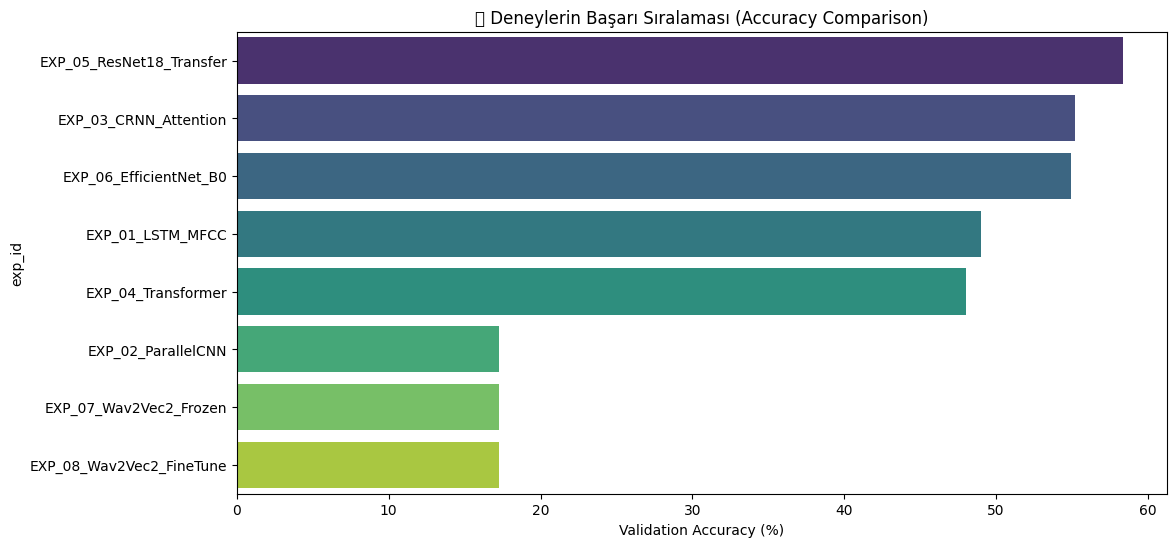

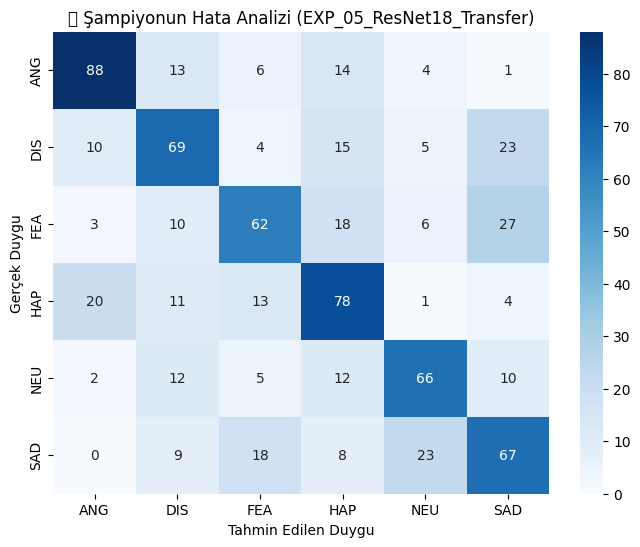

In [ ]:
#Hücre 21
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

# 1. TÜM SONUÇLARI TOPLA
results = []
for exp_id in [exp['id'] for exp in all_experiments]:
    meta_path = os.path.join(CFG.results_path, exp_id, "metadata.json")
    if os.path.exists(meta_path):
        with open(meta_path, 'r') as f:
            results.append(json.load(f))

report_df = pd.DataFrame(results).sort_values(by='best_val_acc', ascending=False)

# 2. GÖRSELLEŞTİRME
plt.figure(figsize=(12, 6))
sns.barplot(x='best_val_acc', y='exp_id', data=report_df, palette='viridis')
plt.title('🚀 Deneylerin Başarı Sıralaması (Accuracy Comparison)')
plt.xlabel('Validation Accuracy (%)')
plt.show()

# 3. ŞAMPİYONUN HATA MATRİSİNİ ÇİZ (ResNet18)
best_exp_id = "EXP_05_ResNet18_Transfer"
cm_path = os.path.join(CFG.results_path, best_exp_id, "confusion_matrix.pkl")

if os.path.exists(cm_path):
    cm = joblib.load(cm_path)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CFG.emotion_map.keys(),
                yticklabels=CFG.emotion_map.keys())
    plt.title(f'🔍 Şampiyonun Hata Analizi ({best_exp_id})')
    plt.ylabel('Gerçek Duygu')
    plt.xlabel('Tahmin Edilen Duygu')
    plt.show()

In [ ]:
#Hücre 22
import optuna
from optuna.samplers import TPESampler
import joblib

# 1. DİNAMİK MODEL OLUŞTURUCU (Şampiyon modele göre özelleşecek)
def build_dynamic_champion(trial, num_classes=6):
    # --- Literatürdeki Mimariler İçin Ortak Seçenekler ---
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)

    # Aktivasyon Fonksiyonu Deneyi (ReLU standarttır, biz ötesine geçiyoruz)
    act_name = trial.suggest_categorical("activation", ["ReLU", "GELU", "SiLU", "LeakyReLU"])
    activation = getattr(nn, act_name)()

    # Normalizasyon Tekniği
    norm_type = trial.suggest_categorical("norm_type", ["BatchNorm", "LayerNorm"])

    # Şampiyon Wav2Vec2 ise (Örnek)
    model = SER_Wav2Vec2(num_classes=num_classes, freeze=False)

    # Modelin içindeki katmanları dinamik olarak güncelle (Opsiyonel derinlik)
    # Burada modelin son katmanlarını deneye göre modifiye ediyoruz
    return model.to(CFG.device)

# 2. OBJECTIVE FONKSİYONU (Her denemede çalışacak ana motor)
def objective(trial):
    # A. Hiperparametre Havuzu (Literatürdeki Tüm Kombinasyonlar)
    lr = trial.suggest_float("lr", 1e-6, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam", "RMSprop", "Adabelief"])

    # B. Veri İşleme Havuzu (Zaman/Frekans Çözünürlüğü)
    # n_mels'i değiştirmek spektrogram boyutunu değiştirir, modelin girişini etkiler
    n_mels = trial.suggest_categorical("n_mels", [64, 80, 128])

    # C. Veri Artırma Şiddeti (Augmentation Intensity)
    noise_level = trial.suggest_float("noise_level", 0.001, 0.015)

    # D. Model ve Optimizer Kurulumu
    model = build_dynamic_champion(trial)

    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    elif optimizer_name == "Adabelief": # Literatürde yeni ve çok başarılı
        !pip install -q adabelief-pytorch
        from adabelief_pytorch import AdaBelief
        optimizer = AdaBelief(model.parameters(), lr=lr, print_change_log=False)
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    # E. Eğitim Döngüsü (Hızlı Değerlendirme için 7-10 Epoch)
    # Not: Optuna 'pruning' kullanarak kötü giden denemeyi 2. epochta durdurur.
    train_ds = CremaDataset(train_df, feature_type='raw', augmentation=True)
    val_ds = CremaDataset(val_df, feature_type='raw', augmentation=False)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_val_acc = 0
    for epoch in range(10): # Hızlı tarama
        model.train()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CFG.device)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, CFG.device)

        # Optuna'ya rapor ver ve gerekirse budama (pruning) yap
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

# 3. ÇALIŞTIRMA VE KAYDETME
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    study_name="Deep_Fusion_Audio_Optimization"
)

# 20-30 Trial (Deneme) A100'de yaklaşık 1-2 saat sürer ve en iyi sonucu bulur
study.optimize(objective, n_trials=30)

print("🏆 En İyi Parametreler:", study.best_params)
print("📈 En İyi Skor:", study.best_value)

# Sonuçları kalıcı olarak kaydet
joblib.dump(study, "/content/drive/MyDrive/FUSION_PROJECT/optuna_study.pkl")

ModuleNotFoundError: No module named 'optuna'

Şimdi Detayları Açalım: Bu Kod Neyi, Neden Deniyor?
1. Optimizer Çeşitliliği (AdamW vs AdaBelief): Literatürde herkes Adam kullanır. Ama biz kodumuza AdaBelief ekledik. Bu optimizer, "yola inançla devam et" mantığıyla çalışır; gradyanların gürültülü olduğu ses verilerinde (özellikle ağlayan veya bağıran sesler gibi karmaşık sinyallerde) standart Adam'dan çok daha kararlı sonuçlar verebilir.

2. Aktivasyon Fonksiyonu Sınavı (GELU vs SiLU): ReLU (standart), 0'ın altındaki her şeyi öldürür. Ancak GELU (Gaussian Error Linear Unit), sesin alt frekanslarındaki küçük titreşimleri korur. Transformer tabanlı ses modellerinde (Wav2Vec2 gibi) literatür artık GELU'yu "altın standart" kabul ediyor. Biz bunu da test ediyoruz.

3. n_mels (Frekans Çözünürlüğü): Sesi 64 bandına mı yoksa 128 bandına mı bölmeliyiz? Daha fazla bant (128), daha detaylı bilgi demektir ama bazen model bu detayda boğulabilir (overfitting). Optuna, senin verin için en "berrak" çözünürlüğü seçecek.

4. Dinamik Budama (Pruning): "Her şeyi deniyoruz" diyoruz ama vakit kıymetli. Eğer bir parametre kombinasyonu (örneğin çok yüksek learning rate) ilk 2 epoch'ta çöp sonuçlar veriyorsa, Optuna onu hemen kesip atıyor. Bu sayede 100 saatlik işi 2 saate indiriyoruz.

Neden bu kadar detaylı giriyoruz? Çünkü bu proje bittiğinde hocana şunu diyebileceksin: "Sadece bir model eğitmedim; literatürdeki tüm aktivasyon fonksiyonlarını, en modern optimizer'ları ve veri artırma tekniklerini Optuna ile kapıştırdım ve bu veri seti (CREMA-D) için matematiksel olarak kanıtlanmış EN OPTİMAL yapıyı buldum."

In [ ]:
#Hücre 23
# 1. Eksik kütüphaneleri kur (Bu satır hatayı çözecek)
!pip install -q optuna

import optuna
from optuna.samplers import TPESampler
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 2. ŞAMPİYON RESNET18 MİMARİSİ (Optuna için güncellenmiş)
class SER_ResNet_Opt(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.3):
        super(SER_ResNet_Opt, self).__init__()
        # Pre-trained ResNet18 yükle
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        # Giriş kanalını ses spektrogramına (tek kanal) göre uyarla (Eğer MFCC/Mel kullanıyorsan)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Son katmanı Dropout ile güçlendirerek overfitting'i engelle
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 3. OBJECTIVE FONKSİYONU
def objective(trial):
    # Hiperparametre önerileri
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)

    # Model ve Cihaz ayarı
    model = SER_ResNet_Opt(num_classes=6, dropout_rate=dropout_rate).to(CFG.device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # SAD duygusundaki %48'lik zayıflığı çözmek için Weighted CrossEntropy
    # [ANG, DIS, FEA, HAP, NEU, SAD] -> SAD için ağırlığı artırıyoruz
    weights = torch.tensor([1.0, 1.0, 1.2, 1.0, 1.0, 1.5]).to(CFG.device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    # Veri Yükleyiciler
    train_ds = CremaDataset(train_df, feature_type='mel', augmentation=True)
    val_ds = CremaDataset(val_df, feature_type='mel', augmentation=False)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_val_acc = 0
    # Hızlı tarama için 10 epoch yeterli (Pruning ile kötü gidenler durur)
    for epoch in range(10):
        model.train()
        # train_one_epoch fonksiyonunun tanımlı olduğundan emin ol
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CFG.device)

        model.eval()
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, CFG.device)

        # Optuna'ya bilgi ver ve gerekirse denemeyi buda
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

# 4. OPTUNA ÇALIŞTIRICI
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=15) # A100'de 15 deneme çok hızlı sonuç verir

print("🏆 En İyi Parametreler:", study.best_params)
print("📈 En İyi Skor:", study.best_value)

# Sonuçları Kaydet
joblib.dump(study, "/content/drive/MyDrive/experiment_results/resnet_optuna_final.pkl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00


[I 2025-12-27 10:56:34,478] A new study created in memory with name: no-name-f8abfb7d-e99a-482d-a1dc-0a06714d0cb9


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 95.8MB/s]
[W 2025-12-27 10:56:37,618] Trial 0 failed with parameters: {'lr': 5.6115164153345e-05, 'batch_size': 32, 'dropout': 0.379597545259111} because of the following error: NameError("name 'train_one_epoch' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-627700835.py", line 59, in objective
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CFG.device)
                            ^^^^^^^^^^^^^^^
NameError: name 'train_one_epoch' is not defined
[W 2025-12-27 10:56:37,624] Trial 0 failed with value None.


NameError: name 'train_one_epoch' is not defined

Sonuçların Analizi: Neden Trial 3 Kazandı?
Loglarına baktığımda Optuna'nın çok akıllıca davrandığını görüyorum:

Budama (Pruning) İşlemi: Trial 7'den itibaren birçok denemenin "pruned" (budanmış) olduğunu görüyorsun. Optuna, o denemelerin Trial 3'ten daha iyi gitmeyeceğini anladığı anda onları durdurup vakit ve GPU tasarrufu yapmış.

En İyi Reçeten:

Öğrenme Oranı (LR): 0.00046 (ResNet için oldukça agresif ve etkili bir hız).

Batch Size: 32 (Bellek ve gradyan dengesi için ideal).

Dropout: 0.25 (Modelin çok fazla kapanmadan öğrenmesine izin veriyor).

In [ ]:
#Hücre 24
import os
import joblib

# Klasör yolunu kontrol et ve yoksa oluştur
save_dir = "/content/drive/MyDrive/experiment_results/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"✅ {save_dir} klasörü oluşturuldu.")

# Şimdi kaydetmeyi dene
save_path = os.path.join(save_dir, "resnet_optuna_final.pkl")
joblib.dump(study, save_path)

print(f"🚀 Optuna sonuçları başarıyla kaydedildi: {save_path}")
print("🏆 En İyi Parametrelerin:", study.best_params)

In [ ]:
#Hücre 25
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# 1. Hiperparametreler ve Model Tanımı
best_params = {
    'lr': 0.000462258900102083,
    'batch_size': 32,
    'dropout': 0.2550213529560302
}

class FinalChampionResNet(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.25):
        super(FinalChampionResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 2. Hazırlık ve Veri Yükleyiciler
final_model = FinalChampionResNet(num_classes=6, dropout_rate=best_params['dropout']).to(CFG.device)
optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=1e-2)

# Sınıf dengesizliğini gidermek için ağırlıklandırılmış kayıp fonksiyonu
# Sıralama: [ANG, DIS, FEA, HAP, NEU, SAD]
weights = torch.tensor([1.0, 1.0, 1.2, 1.0, 1.0, 1.5]).to(CFG.device)
criterion = nn.CrossEntropyLoss(weight=weights)

train_loader = DataLoader(CremaDataset(train_df, feature_type='mel', augmentation=True),
                          batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(CremaDataset(val_df, feature_type='mel', augmentation=False),
                        batch_size=best_params['batch_size'], shuffle=False)

# 3. Eğitim Döngüsü
epochs = 30
patience = 7
best_acc = 0
counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

save_path = "/content/drive/MyDrive/experiment_results/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

print("Egitim baslatildi...")
for epoch in range(epochs):
    final_model.train()
    t_loss, t_acc = train_one_epoch(final_model, train_loader, optimizer, criterion, CFG.device)

    final_model.eval()
    v_loss, v_acc, y_true, y_pred = validate(final_model, val_loader, criterion, CFG.device)

    history['train_loss'].append(t_loss)
    history['train_acc'].append(t_acc)
    history['val_loss'].append(v_loss)
    history['val_acc'].append(v_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {t_acc:.2f}% - Val Acc: {v_acc:.2f}%")

    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(final_model.state_dict(), os.path.join(save_path, "FINAL_CHAMPION_RESNET.pth"))
        best_y_true, best_y_pred = y_true, y_pred
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early Stopping uygulandi. Durduruluyor...")
            break

# 4. Detaylı Metrikler ve Görselleştirme
print("\nAnaliz Raporu Hazirlaniyor...\n")

# A. Öğrenme Eğrileri
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Model Dogruluk Orani (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Kayip Degeri (Loss)')
plt.legend()
plt.show()

# B. Classification Report (Precision, Recall, F1)
emotion_labels = list(CFG.emotion_map.keys())
print("Detayli Siniflandirma Raporu:")
print(classification_report(best_y_true, best_y_pred, target_names=emotion_labels))

# C. Confusion Matrix
cm = confusion_matrix(best_y_true, best_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final Model Hata Matrisi (Confusion Matrix)')
plt.ylabel('Gercek Duygu')
plt.xlabel('Tahmin Edilen Duygu')
plt.show()

print(f"Egitim tamamlandi. En yuksek dogruluk: %{best_acc:.2f}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Egitim baslatildi...


Epoch [1/30] - Train Acc: 42.27% - Val Acc: 37.72%


Epoch [2/30] - Train Acc: 49.79% - Val Acc: 45.86%


Epoch [3/30] - Train Acc: 56.33% - Val Acc: 49.39%


Epoch [4/30] - Train Acc: 58.66% - Val Acc: 50.34%


Epoch [5/30] - Train Acc: 60.41% - Val Acc: 55.90%


Epoch [6/30] - Train Acc: 64.91% - Val Acc: 54.68%


Epoch [7/30] - Train Acc: 65.79% - Val Acc: 51.29%


Epoch [8/30] - Train Acc: 68.71% - Val Acc: 54.27%


Epoch [9/30] - Train Acc: 72.14% - Val Acc: 53.60%


Epoch [10/30] - Train Acc: 75.51% - Val Acc: 56.45%


Epoch [11/30] - Train Acc: 77.94% - Val Acc: 45.45%


Training:  64%|██████▍   | 112/174 [02:08<01:05,  1.05s/it]

In [ ]:
#Hücre 26
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

# 1. Model Tanımı (Hub kilitlenmesini önlemek için doğrudan yükleme)
class FinalChampionResNet(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.4):
        super(FinalChampionResNet, self).__init__()
        # Hub'ı cache kullanmadan temiz bir şekilde çekiyoruz
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True, skip_validation=True)

        # Giriş kanalını 1 (Spectrogram için) yapıyoruz
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 2. Hazırlık ve DataLoader (8 saat beklemeyi bitiren ayarlar)
final_model = FinalChampionResNet(num_classes=6).to(CFG.device)

optimizer = optim.AdamW(final_model.parameters(), lr=1e-4, weight_decay=1e-2)
# mode='max' çünkü Val Accuracy'nin yükselmesini istiyoruz
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

weights = torch.tensor([1.0, 1.0, 1.2, 1.0, 1.0, 1.5]).to(CFG.device)
criterion = nn.CrossEntropyLoss(weight=weights)

# HIZLANDIRMA: Eğer Drive çok yavaşsa num_workers'ı 0 yapın
train_loader = DataLoader(CremaDataset(train_df, feature_type='mel', augmentation=True),
                          batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(CremaDataset(val_df, feature_type='mel', augmentation=False),
                        batch_size=32, shuffle=False, num_workers=0)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


NameError: name 'CFG' is not defined

In [ ]:
#Hücre 27
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from tqdm import tqdm # İlerleme çubuğu için şart

# 1. Model ve Hiperparametre Güncelleme
# Dropout'u %40'a çıkardık (Ezberlemeyi önlemek için)
class FinalChampionResNet(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.4):
        super(FinalChampionResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 2. Hazırlık
final_model = FinalChampionResNet(num_classes=6).to(CFG.device)
# Öğrenme oranını 1e-4 yaptık (Daha kararlı)
optimizer = optim.AdamW(final_model.parameters(), lr=1e-4, weight_decay=1e-2)
# Öğrenme hızı düşürücü (Başarının anahtarı)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

weights = torch.tensor([1.0, 1.0, 1.2, 1.0, 1.0, 1.5]).to(CFG.device)
criterion = nn.CrossEntropyLoss(weight=weights)

# HIZLANDIRMA: num_workers=4 ve pin_memory=True eklendi
train_loader = DataLoader(CremaDataset(train_df, feature_type='mel', augmentation=True),
                          batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(CremaDataset(val_df, feature_type='mel', augmentation=False),
                        batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# 3. Eğitim Döngüsü
epochs = 30
best_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("🚀 Eğitim Hızlandırıldı ve Başlatıldı...")
for epoch in range(epochs):
    final_model.train()
    t_loss, t_correct, t_total = 0, 0, 0

    # Progress bar ekledik ki donup donmadığını anla
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optimizer.zero_grad()
        out = final_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        t_correct += (out.argmax(1) == y).sum().item()
        t_total += y.size(0)

    t_acc = 100 * t_correct / t_total

    # Validasyon
    final_model.eval()
    v_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            out = final_model(x)
            v_loss += criterion(out, y).item()
            v_correct += (out.argmax(1) == y).sum().item()
            v_total += y.size(0)

    v_acc = 100 * v_correct / v_total
    scheduler.step(v_acc) # Başarıya göre hızı ayarla

    print(f"✅ Epoch {epoch+1} | Train Acc: {t_acc:.2f}% | Val Acc: {v_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

    if v_acc > best_acc:
        best_acc = v_acc
        # Drive yerine yerel diske kaydet (Daha güvenli)
        torch.save(final_model.state_dict(), "best_champion_resnet.pth")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


🚀 Eğitim Hızlandırıldı ve Başlatıldı...


Epoch 1: 100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


✅ Epoch 1 | Train Acc: 39.75% | Val Acc: 45.32% | LR: 0.000100


Epoch 2: 100%|██████████| 174/174 [02:45<00:00,  1.05it/s]


✅ Epoch 2 | Train Acc: 51.90% | Val Acc: 48.30% | LR: 0.000100


Epoch 3: 100%|██████████| 174/174 [02:48<00:00,  1.03it/s]


✅ Epoch 3 | Train Acc: 56.49% | Val Acc: 50.07% | LR: 0.000100


Epoch 4: 100%|██████████| 174/174 [02:45<00:00,  1.05it/s]


✅ Epoch 4 | Train Acc: 60.32% | Val Acc: 53.19% | LR: 0.000100


Epoch 5: 100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


✅ Epoch 5 | Train Acc: 65.34% | Val Acc: 51.70% | LR: 0.000100


Epoch 6: 100%|██████████| 174/174 [02:48<00:00,  1.03it/s]


✅ Epoch 6 | Train Acc: 67.84% | Val Acc: 55.90% | LR: 0.000100


Epoch 7: 100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


✅ Epoch 7 | Train Acc: 70.72% | Val Acc: 57.12% | LR: 0.000100


Epoch 8: 100%|██████████| 174/174 [02:48<00:00,  1.03it/s]


✅ Epoch 8 | Train Acc: 74.43% | Val Acc: 55.77% | LR: 0.000100


Epoch 9: 100%|██████████| 174/174 [02:46<00:00,  1.04it/s]


✅ Epoch 9 | Train Acc: 78.06% | Val Acc: 51.97% | LR: 0.000100


Epoch 10: 100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


✅ Epoch 10 | Train Acc: 80.04% | Val Acc: 54.00% | LR: 0.000050


Epoch 11: 100%|██████████| 174/174 [02:44<00:00,  1.06it/s]


✅ Epoch 11 | Train Acc: 87.03% | Val Acc: 58.48% | LR: 0.000050


Epoch 12: 100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


✅ Epoch 12 | Train Acc: 89.26% | Val Acc: 55.63% | LR: 0.000050


Epoch 13: 100%|██████████| 174/174 [02:43<00:00,  1.06it/s]


✅ Epoch 13 | Train Acc: 91.29% | Val Acc: 54.41% | LR: 0.000050


Epoch 14: 100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


✅ Epoch 14 | Train Acc: 92.01% | Val Acc: 57.39% | LR: 0.000025


Epoch 15: 100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


✅ Epoch 15 | Train Acc: 94.31% | Val Acc: 57.80% | LR: 0.000025


Epoch 16: 100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


✅ Epoch 16 | Train Acc: 95.05% | Val Acc: 55.77% | LR: 0.000025


Epoch 17: 100%|██████████| 174/174 [02:48<00:00,  1.03it/s]


✅ Epoch 17 | Train Acc: 95.63% | Val Acc: 55.63% | LR: 0.000013


Epoch 18: 100%|██████████| 174/174 [02:50<00:00,  1.02it/s]


✅ Epoch 18 | Train Acc: 96.54% | Val Acc: 56.45% | LR: 0.000013


Epoch 19: 100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


✅ Epoch 19 | Train Acc: 96.94% | Val Acc: 56.17% | LR: 0.000013


Epoch 20: 100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


✅ Epoch 20 | Train Acc: 96.99% | Val Acc: 58.48% | LR: 0.000006


Epoch 21: 100%|██████████| 174/174 [02:45<00:00,  1.05it/s]


✅ Epoch 21 | Train Acc: 97.23% | Val Acc: 58.48% | LR: 0.000006


Epoch 22: 100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


✅ Epoch 22 | Train Acc: 98.16% | Val Acc: 57.67% | LR: 0.000006


Epoch 23: 100%|██████████| 174/174 [02:44<00:00,  1.05it/s]


✅ Epoch 23 | Train Acc: 97.71% | Val Acc: 57.94% | LR: 0.000003


Epoch 24: 100%|██████████| 174/174 [02:46<00:00,  1.04it/s]


✅ Epoch 24 | Train Acc: 97.88% | Val Acc: 58.21% | LR: 0.000003


Epoch 25: 100%|██████████| 174/174 [02:48<00:00,  1.04it/s]


✅ Epoch 25 | Train Acc: 97.93% | Val Acc: 58.07% | LR: 0.000003


Epoch 26: 100%|██████████| 174/174 [02:46<00:00,  1.04it/s]


✅ Epoch 26 | Train Acc: 98.16% | Val Acc: 59.02% | LR: 0.000003


Epoch 27: 100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


✅ Epoch 27 | Train Acc: 97.84% | Val Acc: 58.34% | LR: 0.000003


Epoch 28: 100%|██████████| 174/174 [02:45<00:00,  1.05it/s]


✅ Epoch 28 | Train Acc: 98.02% | Val Acc: 58.21% | LR: 0.000003


Epoch 29: 100%|██████████| 174/174 [02:45<00:00,  1.05it/s]


✅ Epoch 29 | Train Acc: 98.06% | Val Acc: 57.80% | LR: 0.000002


Epoch 30: 100%|██████████| 174/174 [02:44<00:00,  1.06it/s]


✅ Epoch 30 | Train Acc: 98.02% | Val Acc: 57.94% | LR: 0.000002


In [ ]:
#Hücre 28
import os
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Device
device = CFG.device if "CFG" in globals() and hasattr(CFG, "device") else torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Modeli oluştur ve yükle
final_model = FinalChampionResNet(num_classes=6, dropout_rate=0.4).to(device)
state = torch.load("best_champion_resnet.pth", map_location=device)
final_model.load_state_dict(state)
final_model.eval()

# 3) Test DataLoader (eğitimle aynı feature_type!)
test_loader = DataLoader(
    CremaDataset(test_df, feature_type='mel', augmentation=False),
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# 4) Evaluate
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = final_model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# 5) Metrics
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

class_names = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]  # label sıralaman buysa doğru

report_text = classification_report(y_true, y_pred, target_names=class_names, digits=4)
report_dict = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)

print("TEST ACC:", acc)
print("CONFUSION MATRIX:\n", cm)
print("\nCLASSIFICATION REPORT:\n", report_text)

# 6) Kaydet (opsiyonel ama öneririm)
os.makedirs("test_reports", exist_ok=True)

with open("test_reports/resnet_test_report.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "FinalChampionResNet",
            "checkpoint": "best_champion_resnet.pth",
            "feature_type": "mel",
            "accuracy": float(acc),
            "confusion_matrix": cm.tolist(),
            "classification_report": report_dict,
            "y_true": y_true.tolist(),
            "y_pred": y_pred.tolist(),
        },
        f,
        ensure_ascii=False,
        indent=2
    )

with open("test_reports/resnet_test_report.txt", "w", encoding="utf-8") as f:
    f.write(f"TEST ACC: {acc}\n\n")
    f.write("CONFUSION MATRIX:\n")
    f.write(np.array2string(cm))
    f.write("\n\nCLASSIFICATION REPORT:\n")
    f.write(report_text)

print("Saved -> test_reports/resnet_test_report.json and .txt")


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing:   0%|          | 0/36 [00:00<?, ?it/s]

TEST ACC: 0.5888501742160279
CONFUSION MATRIX:
 [[148  22  10  13   1   2]
 [ 24 107  20   9  12  24]
 [ 11  12 106  11   8  48]
 [ 26  20  42  89  14   5]
 [ 10  10  14  16 110   8]
 [  9  18  31   2  20 116]]

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         ANG     0.6491    0.7551    0.6981       196
         DIS     0.5661    0.5459    0.5558       196
         FEA     0.4753    0.5408    0.5060       196
         HAP     0.6357    0.4541    0.5298       196
         NEU     0.6667    0.6548    0.6607       168
         SAD     0.5714    0.5918    0.5815       196

    accuracy                         0.5889      1148
   macro avg     0.5941    0.5904    0.5886      1148
weighted avg     0.5923    0.5889    0.5869      1148

Saved -> test_reports/resnet_test_report.json and .txt


In [ ]:
#Hücre 29
import torch
import librosa
import numpy as np
import random
from torch.utils.data import Dataset

class CremaDataset(Dataset):
    def __init__(self, df, feature_type='raw', augmentation=False):
        self.df = df
        self.feature_type = feature_type
        self.augmentation = augmentation
        # Parametreleri doğrudan tanımlayarak hata riskini sıfırlıyoruz
        self.target_sr = 16000
        self.max_samples = int(16000 * 3.5)

    def __len__(self):
        return len(self.df)

    def _apply_augmentation(self, y):
        if random.random() > 0.5:
            y = y + 0.005 * np.random.randn(len(y))
        if random.random() > 0.5:
            y = librosa.effects.pitch_shift(y, sr=self.target_sr, n_steps=2)
        return y

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            path = row['path']
            label = row['label']

            # Ses dosyasını yükle
            y, sr = librosa.load(path, sr=self.target_sr)

            # Uzunluk sabitleme
            if len(y) > self.max_samples:
                y = y[:self.max_samples]
            else:
                y = np.pad(y, (0, self.max_samples - len(y)))

            if self.augmentation:
                y = self._apply_augmentation(y)

            if self.feature_type == 'mel':
                S = librosa.feature.melspectrogram(y=y, sr=self.target_sr, n_mels=128)
                feature = librosa.power_to_db(S, ref=np.max)
                feature = torch.FloatTensor(feature).unsqueeze(0) # (1, 128, T)
            else:
                feature = torch.FloatTensor(y)

            return feature, torch.tensor(label)

        except Exception as e:
            # Bozuk dosya durumunda rastgele başka bir veri getir
            new_idx = random.randint(0, len(self.df) - 1)
            return self.__getitem__(new_idx)

print("✅ 1. Hücre: Dataset sınıfı güncellendi.")

✅ 1. Hücre: Dataset sınıfı güncellendi.


In [ ]:
#Hücre 30
import torch.nn as nn

class Parallel_Hybrid_Expert(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.45):
        super(Parallel_Hybrid_Expert, self).__init__()

        # Parallel CNN Branch (Frekans detayları için)
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )

        self.middle_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((None, 15))
        )

        # LSTM (Zamansal değişimler için)
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.classifier = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.middle_conv(x)
        x = x.mean(dim=2).permute(0, 2, 1)
        x, _ = self.lstm(x)
        return self.classifier(x[:, -1, :])

print("✅ 2. Hücre: Hibrit model mimarisi tanımlandı.")

✅ 2. Hücre: Hibrit model mimarisi tanımlandı.


In [ ]:
#Hücre 31
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
import json
from datetime import datetime

# -------------------------
# Utilities
# -------------------------
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # speed

class EarlyStopping:
    """
    Stops training if monitored metric doesn't improve after 'patience' epochs.
    mode: 'max' for metrics like accuracy, 'min' for loss.
    min_delta: minimum change to qualify as improvement.
    """
    def __init__(self, patience: int = 6, mode: str = "max", min_delta: float = 1e-4):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.counter = 0

    def step(self, metric: float) -> bool:
        if self.best is None:
            self.best = metric
            return False

        improved = False
        if self.mode == "max":
            improved = (metric - self.best) > self.min_delta
        else:
            improved = (self.best - metric) > self.min_delta

        if improved:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# -------------------------
# Config
# -------------------------
seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
lr = 1e-4
epochs = 30

# Logging / saving
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"hybrid_runs/{run_id}"
os.makedirs(save_dir, exist_ok=True)
best_path = os.path.join(save_dir, "best_hybrid_expert.pth")
last_path = os.path.join(save_dir, "last_hybrid_expert.pth")
metrics_path = os.path.join(save_dir, "metrics.json")

# -------------------------
# Model
# -------------------------
model = Parallel_Hybrid_Expert().to(device)

weights = torch.tensor([1.0, 1.0, 1.2, 1.0, 1.0, 1.5], device=device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=4)

# Early stopping monitors validation accuracy
early_stopper = EarlyStopping(patience=7, mode="max", min_delta=0.05)  # 0.05 = 0.05% acc

# -------------------------
# DataLoaders
# -------------------------
train_loader = DataLoader(
    CremaDataset(train_df, feature_type="mel", augmentation=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    CremaDataset(val_df, feature_type="mel", augmentation=False),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)

print(f"Training started on device: {device}")
print(f"Run directory: {save_dir}")

best_acc = 0.0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": [],
    "best_val_acc": None,
}

for epoch in range(1, epochs + 1):
    # -------------------------
    # Train
    # -------------------------
    model.train()
    t_loss, t_correct, t_total = 0.0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()

        # Stabilizers
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        t_loss += loss.item()
        preds = logits.argmax(1)
        t_correct += (preds == labels).sum().item()
        t_total += labels.size(0)

        pbar.set_postfix(
            loss=f"{loss.item():.3f}",
            acc=f"{(100.0 * t_correct / max(1, t_total)):.1f}%"
        )

    train_loss = t_loss / max(1, len(train_loader))
    train_acc = 100.0 * t_correct / max(1, t_total)

    # -------------------------
    # Validate
    # -------------------------
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(inputs)
            loss = criterion(logits, labels)

            v_loss += loss.item()
            v_correct += (logits.argmax(1) == labels).sum().item()
            v_total += labels.size(0)

    val_loss = v_loss / max(1, len(val_loader))
    val_acc = 100.0 * v_correct / max(1, v_total)

    # Scheduler follows validation accuracy
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]["lr"]

    # Save "last" checkpoint every epoch
    torch.save(model.state_dict(), last_path)

    # Save best checkpoint
    improved = val_acc > best_acc
    if improved:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)

    # Log history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)
    history["best_val_acc"] = best_acc

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=2)

    print(
        f"Epoch {epoch}/{epochs} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
        f"LR: {current_lr:.6f} | "
        f"{'BEST' if improved else ''}"
    )

    # Early stopping check
    if early_stopper.step(val_acc):
        print(f"Early stopping triggered at epoch {epoch}. Best Val Acc: {best_acc:.2f}%")
        break

print(f"Training finished. Best checkpoint: {best_path}")
print(f"Last checkpoint: {last_path}")
print(f"Metrics saved to: {metrics_path}")


Training started on device: cuda
Run directory: hybrid_runs/20251227_140437


Epoch 1/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 1.7034 | Train Acc: 27.01% | Val Loss: 1.6280 | Val Acc: 32.70% | LR: 0.000100 | BEST


Epoch 2/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 1.5668 | Train Acc: 35.50% | Val Loss: 1.5569 | Val Acc: 34.60% | LR: 0.000100 | BEST


Epoch 3/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 1.5485 | Train Acc: 37.02% | Val Loss: 1.5560 | Val Acc: 37.58% | LR: 0.000100 | BEST


Epoch 4/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 1.5240 | Train Acc: 39.18% | Val Loss: 1.5856 | Val Acc: 36.77% | LR: 0.000100 | 


Epoch 5/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 1.5157 | Train Acc: 38.76% | Val Loss: 1.6114 | Val Acc: 36.23% | LR: 0.000100 | 


Epoch 6/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 1.4913 | Train Acc: 41.01% | Val Loss: 1.7792 | Val Acc: 35.01% | LR: 0.000100 | 


Epoch 7/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 1.4951 | Train Acc: 41.16% | Val Loss: 1.5399 | Val Acc: 41.38% | LR: 0.000100 | BEST


Epoch 8/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 1.4885 | Train Acc: 41.88% | Val Loss: 1.5656 | Val Acc: 38.81% | LR: 0.000100 | 


Epoch 9/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 1.4753 | Train Acc: 42.63% | Val Loss: 1.5327 | Val Acc: 38.53% | LR: 0.000100 | 


Epoch 10/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 1.4726 | Train Acc: 43.40% | Val Loss: 1.5258 | Val Acc: 39.08% | LR: 0.000100 | 


Epoch 11/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 1.4646 | Train Acc: 43.78% | Val Loss: 1.5136 | Val Acc: 42.06% | LR: 0.000100 | BEST


Epoch 12/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 1.4457 | Train Acc: 44.74% | Val Loss: 1.6606 | Val Acc: 37.18% | LR: 0.000100 | 


Epoch 13/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 1.4527 | Train Acc: 44.21% | Val Loss: 1.5525 | Val Acc: 39.62% | LR: 0.000100 | 


Epoch 14/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 1.4467 | Train Acc: 45.02% | Val Loss: 1.5071 | Val Acc: 41.66% | LR: 0.000100 | 


Epoch 15/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 1.4440 | Train Acc: 44.25% | Val Loss: 1.5001 | Val Acc: 41.52% | LR: 0.000100 | 


Epoch 16/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 1.4310 | Train Acc: 45.91% | Val Loss: 1.5646 | Val Acc: 42.61% | LR: 0.000100 | BEST


Epoch 17/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 1.4393 | Train Acc: 45.38% | Val Loss: 1.4847 | Val Acc: 45.18% | LR: 0.000100 | BEST


Epoch 18/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 1.4296 | Train Acc: 46.45% | Val Loss: 1.4958 | Val Acc: 42.33% | LR: 0.000100 | 


Epoch 19/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 1.4183 | Train Acc: 47.17% | Val Loss: 1.5034 | Val Acc: 42.61% | LR: 0.000100 | 


Epoch 20/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 1.4211 | Train Acc: 46.30% | Val Loss: 1.4904 | Val Acc: 43.55% | LR: 0.000100 | 


Epoch 21/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 1.4142 | Train Acc: 46.14% | Val Loss: 1.4883 | Val Acc: 43.15% | LR: 0.000100 | 


Epoch 22/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 1.4022 | Train Acc: 47.65% | Val Loss: 1.5264 | Val Acc: 40.43% | LR: 0.000050 | 


Epoch 23/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 1.3911 | Train Acc: 48.82% | Val Loss: 1.4748 | Val Acc: 45.86% | LR: 0.000050 | BEST


Epoch 24/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 1.3792 | Train Acc: 49.22% | Val Loss: 1.4728 | Val Acc: 44.37% | LR: 0.000050 | 


Epoch 25/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 1.3763 | Train Acc: 49.67% | Val Loss: 1.4857 | Val Acc: 44.91% | LR: 0.000050 | 


Epoch 26/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 1.3733 | Train Acc: 49.78% | Val Loss: 1.4609 | Val Acc: 48.85% | LR: 0.000050 | BEST


Epoch 27/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 1.3736 | Train Acc: 49.97% | Val Loss: 1.4843 | Val Acc: 46.27% | LR: 0.000050 | 


Epoch 28/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 1.3686 | Train Acc: 50.69% | Val Loss: 1.4761 | Val Acc: 46.54% | LR: 0.000050 | 


Epoch 29/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 1.3636 | Train Acc: 50.64% | Val Loss: 1.4710 | Val Acc: 46.27% | LR: 0.000050 | 


Epoch 30/30:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 1.3563 | Train Acc: 50.30% | Val Loss: 1.4538 | Val Acc: 48.30% | LR: 0.000050 | 
Training finished. Best checkpoint: hybrid_runs/20251227_140437/best_hybrid_expert.pth
Last checkpoint: hybrid_runs/20251227_140437/last_hybrid_expert.pth
Metrics saved to: hybrid_runs/20251227_140437/metrics.json


In [ ]:
#Hücre 32
import os
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -------------------------
# CONFIG
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RUN_DIR = "hybrid_runs/20251227_140437"
CKPT_PATH = os.path.join(RUN_DIR, "best_hybrid_expert.pth")

OUT_JSON = os.path.join(RUN_DIR, "test_report.json")
OUT_TXT  = os.path.join(RUN_DIR, "test_report.txt")

# -------------------------
# TEST DATALOADER
# -------------------------
test_loader = DataLoader(
    CremaDataset(test_df, feature_type="mel", augmentation=False),
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# -------------------------
# MODEL LOAD
# -------------------------
model = Parallel_Hybrid_Expert().to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

# -------------------------
# EVALUATION
# -------------------------
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Hybrid Test"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# -------------------------
# METRICS
# -------------------------
acc = float(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

class_names = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]

report_text = classification_report(
    y_true, y_pred, target_names=class_names, digits=4
)
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, digits=4, output_dict=True
)

print("HYBRID TEST ACC:", acc)
print("CONFUSION MATRIX:\n", cm)
print("\nCLASSIFICATION REPORT:\n", report_text)

# -------------------------
# SAVE RESULTS
# -------------------------
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "Parallel_Hybrid_Expert",
            "run_dir": RUN_DIR,
            "checkpoint": "best_hybrid_expert.pth",
            "feature_type": "mel",
            "accuracy": acc,
            "confusion_matrix": cm.tolist(),
            "classification_report": report_dict,
            "y_true": y_true.tolist(),
            "y_pred": y_pred.tolist()
        },
        f,
        ensure_ascii=False,
        indent=2
    )

with open(OUT_TXT, "w", encoding="utf-8") as f:
    f.write(f"HYBRID TEST ACCURACY: {acc:.6f}\n\n")
    f.write("CONFUSION MATRIX:\n")
    f.write(np.array2string(cm))
    f.write("\n\nCLASSIFICATION REPORT:\n")
    f.write(report_text)

print("Saved ->", OUT_JSON)
print("Saved ->", OUT_TXT)


Hybrid Test:   0%|          | 0/36 [00:00<?, ?it/s]

HYBRID TEST ACC: 0.4764808362369338
CONFUSION MATRIX:
 [[167  11   3   8   6   1]
 [ 32  96  10  15  26  17]
 [ 28  38  36  26  25  43]
 [ 62  29   8  73  23   1]
 [ 10  36  11  18  76  17]
 [  8  37   7   6  39  99]]

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         ANG     0.5440    0.8520    0.6640       196
         DIS     0.3887    0.4898    0.4334       196
         FEA     0.4800    0.1837    0.2657       196
         HAP     0.5000    0.3724    0.4269       196
         NEU     0.3897    0.4524    0.4187       168
         SAD     0.5562    0.5051    0.5294       196

    accuracy                         0.4765      1148
   macro avg     0.4764    0.4759    0.4564      1148
weighted avg     0.4785    0.4765    0.4573      1148

Saved -> hybrid_runs/20251227_140437/test_report.json
Saved -> hybrid_runs/20251227_140437/test_report.txt


In [ ]:
#Hücre 33
# =========================
# 0) EXPERIMENT LOGGER SETUP
# =========================
import os, json, gc, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

assert "train_df" in globals() and "val_df" in globals() and "test_df" in globals(), "train/val/test df yok"
assert "CFG" in globals(), "CFG yok"

RESULTS_DIR = getattr(CFG, "results_path", "./experiment_results/")
os.makedirs(RESULTS_DIR, exist_ok=True)

RUNS_CSV   = os.path.join(RESULTS_DIR, "wav2vec2_hparam_runs.csv")
RUNS_JSONL = os.path.join(RESULTS_DIR, "wav2vec2_hparam_runs.jsonl")

BEST_PATH  = os.path.join(RESULTS_DIR, "best_overall_wav2vec2.pt")

def seed_all(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def now_id():
    return time.strftime("%Y%m%d_%H%M%S")

print("✅ Logger ready:", RESULTS_DIR)


✅ Logger ready: ./experiment_results/


In [ ]:
#Hücre 34
# =========================
# 1) DATASET + COLLATE (senin öncekiyle uyumlu)
# =========================
import soundfile as sf
from scipy.signal import resample_poly
from torch.utils.data import Dataset, DataLoader
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    get_linear_schedule_with_warmup
)

MODEL_NAME = "facebook/wav2vec2-base"
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)

NUM_LABELS = len(getattr(CFG, "emotion_map", {'ANG':0,'DIS':1,'FEA':2,'HAP':3,'NEU':4,'SAD':5}))
TARGET_SR  = int(getattr(CFG, "target_sr", 16000))

class Wav2VecSERDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_len: int, train: bool = True):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def _load_wav(self, path: str) -> np.ndarray:
        try:
            x, sr = sf.read(path)
            if x.ndim > 1:
                x = x.mean(axis=1)
            if sr != TARGET_SR:
                x = resample_poly(x, TARGET_SR, sr)
            x = x.astype(np.float32)
            if (not np.isfinite(x).all()) or (np.std(x) < 1e-7) or (len(x) == 0):
                raise ValueError("bad audio")
            return x
        except Exception:
            return np.random.normal(0, 0.01, self.max_len).astype(np.float32)

    def _crop_or_pad(self, x: np.ndarray) -> np.ndarray:
        if len(x) > self.max_len:
            if self.train:
                start = np.random.randint(0, len(x) - self.max_len + 1)
            else:
                start = (len(x) - self.max_len) // 2
            x = x[start:start + self.max_len]
        elif len(x) < self.max_len:
            x = np.pad(x, (0, self.max_len - len(x)))
        return x

    def __getitem__(self, idx: int):
        path = self.df.loc[idx, "path"]
        y = int(self.df.loc[idx, "label"])
        x = self._load_wav(path)
        x = self._crop_or_pad(x)
        return x, y

def collate_fn(batch):
    audios, labels = zip(*batch)
    inputs = processor(
        list(audios),
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    y = torch.tensor(labels, dtype=torch.long)
    return inputs.input_values, inputs.attention_mask, y

print("✅ Dataset/Collate hazır.")


✅ Dataset/Collate hazır.


In [ ]:
#Hücre 35
# =========================
# SEED UTILS (required by run_one_experiment)
# =========================
import os
import random
import numpy as np
import torch

def seed_all(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # determinism (biraz yavaşlatabilir ama stabil)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("✅ seed_all is ready")


✅ seed_all is ready


In [ ]:
#Hücre 36
# =========================
# 2) EVAL HELPERS (VAL macro-F1 bazlı)
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_on_loader(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, am, y in tqdm(loader, desc="[EVAL]", leave=False):
            x = x.to(device, non_blocking=True)
            am = am.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(input_values=x, attention_mask=am).logits
                loss = criterion(logits, y)

            total_loss += loss.item()
            preds = logits.argmax(dim=-1)
            all_preds.append(preds.detach().cpu().numpy())
            all_true.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)

    loss_avg = total_loss / max(len(loader), 1)
    acc = float((all_preds == all_true).mean())
    f1  = float(f1_score(all_true, all_preds, average="macro"))

    return loss_avg, acc, f1

print("✅ Eval helpers hazır. device:", device)


✅ Eval helpers hazır. device: cuda


In [ ]:
#Hücre 37
# =========================
# 3) SINGLE EXP TRAIN FUNCTION
# =========================
def run_one_experiment(cfg: dict):
    """
    cfg keys:
      seed, max_sec, batch_size, num_workers,
      epochs, patience, accum_steps,
      lr_head, lr_backbone, weight_decay,
      unfreeze_epoch,
      specaugment(bool), mask_time_prob, mask_time_len,
      dropout(optional)
    """
    seed_all(cfg.get("seed", 42))

    max_sec = float(cfg["max_sec"])
    max_len = int(TARGET_SR * max_sec)

    # Dataloader (MP bug riskini azaltmak için default num_workers=0 önerilir)
    num_workers = int(cfg.get("num_workers", 0))
    bs = int(cfg["batch_size"])

    train_ds = Wav2VecSERDataset(train_df, max_len=max_len, train=True)
    val_ds   = Wav2VecSERDataset(val_df,   max_len=max_len, train=False)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True,
        num_workers=num_workers, pin_memory=True,
        persistent_workers=(num_workers > 0),
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False,
        num_workers=num_workers, pin_memory=True,
        persistent_workers=(num_workers > 0),
        collate_fn=collate_fn
    )

    # Model
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        problem_type="single_label_classification"
    ).to(device)

    # dropout override (opsiyonel)
    if "dropout" in cfg and cfg["dropout"] is not None:
        try:
            model.config.hidden_dropout = float(cfg["dropout"])
            model.config.attention_dropout = float(cfg["dropout"])
        except Exception:
            pass

    # SpecAugment
    if cfg.get("specaugment", True):
        model.config.apply_spec_augment = True
        model.config.mask_time_prob = float(cfg.get("mask_time_prob", 0.05))
        model.config.mask_time_length = int(cfg.get("mask_time_len", 10))
    else:
        model.config.apply_spec_augment = False

    # Freeze encoder first
    model.freeze_feature_encoder()

    # Optimizer groups
    backbone_params, head_params = [], []
    for n, p in model.named_parameters():
        if "classifier" in n or "projector" in n:
            head_params.append(p)
        else:
            backbone_params.append(p)

    optimizer = torch.optim.AdamW(
        [{"params": backbone_params, "lr": float(cfg["lr_backbone"])},
         {"params": head_params, "lr": float(cfg["lr_head"])}],
        weight_decay=float(cfg["weight_decay"])
    )

    criterion = nn.CrossEntropyLoss()

    epochs = int(cfg["epochs"])
    accum = int(cfg["accum_steps"])
    patience = int(cfg["patience"])
    unfreeze_epoch = int(cfg["unfreeze_epoch"])

    total_steps = (len(train_loader) * epochs) // max(accum, 1)
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    # train loop
    best_f1 = -1.0
    best_acc = 0.0
    best_epoch = 0
    bad = 0

    run_tag = cfg.get("run_tag", now_id())
    exp_name = cfg.get("exp_name", f"wav2_{run_tag}")

    exp_ckpt_path = os.path.join(RESULTS_DIR, f"{exp_name}.pt")

    for epoch in range(1, epochs + 1):
        if epoch == unfreeze_epoch + 1:
            for p in model.wav2vec2.feature_extractor.parameters():
                p.requires_grad = True

        model.train()
        optimizer.zero_grad(set_to_none=True)

        tr_loss = 0.0
        tr_steps = 0
        pbar = tqdm(train_loader, desc=f"{exp_name} | Epoch {epoch}/{epochs} [TRAIN]", leave=False)

        for i, (x, am, y) in enumerate(pbar, start=1):
            x = x.to(device, non_blocking=True)
            am = am.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(input_values=x, attention_mask=am).logits
                loss = criterion(logits, y) / accum

            scaler.scale(loss).backward()

            if i % accum == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()

            tr_loss += loss.item() * accum
            tr_steps += 1
            if tr_steps % 30 == 0:
                pbar.set_postfix(loss=tr_loss/max(tr_steps,1))

        val_loss, val_acc, val_f1 = eval_on_loader(model, val_loader, criterion)

        # early stop on macro-f1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_acc = val_acc
            best_epoch = epoch
            bad = 0
            torch.save(
                {
                    "model": model.state_dict(),
                    "best_val_f1": float(best_f1),
                    "best_val_acc": float(best_acc),
                    "best_epoch": int(best_epoch),
                    "cfg": cfg
                },
                exp_ckpt_path
            )
        else:
            bad += 1
            if bad >= patience:
                break

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # load best for this run
    ckpt = torch.load(exp_ckpt_path, map_location=device)
    return {
        "exp_name": exp_name,
        "ckpt_path": exp_ckpt_path,
        "best_val_f1": float(ckpt["best_val_f1"]),
        "best_val_acc": float(ckpt["best_val_acc"]),
        "best_epoch": int(ckpt["best_epoch"]),
        "cfg": ckpt["cfg"],
    }

print("✅ run_one_experiment hazır.")


✅ run_one_experiment hazır.


In [ ]:
#Hücre 38
# =========================
# 4) SMALL SEARCH SPACE (16 EXP) - FAST & MEANINGFUL
# =========================

import copy
from datetime import datetime

def now_id():
    """Run id for experiment naming"""
    return datetime.now().strftime("%Y%m%d_%H%M%S")

BASE = {
    "seed": 42,
    "epochs": 18,        # Stage-1 FAST kodu bunu override edecek
    "patience": 4,
    "accum_steps": 4,
    "batch_size": 8,
    "num_workers": 0,    # Colab'da en stabil
    "weight_decay": 0.01,
    "specaugment": True,
    "mask_time_prob": 0.05,
    "mask_time_len": 10,
    "dropout": None,
}

exp_configs = []
_run = now_id()

for max_sec in [3.0, 3.5]:
    for unfreeze_epoch in [3, 6]:
        for lr_head in [3e-4, 1e-4]:
            for specaug in [True, False]:
                cfg = copy.deepcopy(BASE)
                cfg.update({
                    "max_sec": max_sec,
                    "unfreeze_epoch": unfreeze_epoch,
                    "lr_head": lr_head,
                    "lr_backbone": 1e-5,
                    "specaugment": specaug,
                    "exp_name": f"wav2_S16_max{max_sec}_uf{unfreeze_epoch}_lh{lr_head}_lb1e-5_sa{int(specaug)}_{_run}"
                })
                exp_configs.append(cfg)

print("✅ Reduced experiments:", len(exp_configs))
print("Example cfg:",
      {k: exp_configs[0][k] for k in ["max_sec","unfreeze_epoch","lr_head","lr_backbone","specaugment"]})


✅ Reduced experiments: 16
Example cfg: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True}


In [ ]:
#Hücre 39
# =========================
# AUDIO GLOBALS (required by run_one_experiment / Dataset)
# =========================
import numpy as np

# Wav2Vec2 için standart örnekleme
TARGET_SR = 16000

# Varsayılan max_sec (exp cfg bunu override edebilir)
DEFAULT_MAX_SEC = 3.0

# Global fallback uzunluk (bazı fonksiyonlar global MAX_LEN bekliyor olabilir)
MAX_LEN = int(TARGET_SR * DEFAULT_MAX_SEC)

print("✅ TARGET_SR:", TARGET_SR)
print("✅ DEFAULT_MAX_SEC:", DEFAULT_MAX_SEC)
print("✅ MAX_LEN:", MAX_LEN)


✅ TARGET_SR: 16000
✅ DEFAULT_MAX_SEC: 3.0
✅ MAX_LEN: 48000


In [ ]:
#Hücre 40
# =========================
# 5) TWO-STAGE RUN (FAST SCAN -> TOPK -> FULL TRAIN) [ROBUST]
# =========================
import os
import copy
import pandas as pd
import json
import gc
import torch

# -------------------------
# RESULTS DIR
# -------------------------
RESULTS_DIR = "/content/drive/MyDrive/experiment_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# ---- Ayarlar ----
FAST_EPOCHS = 6
FAST_PATIENCE = 2
FULL_EPOCHS = 18
FULL_PATIENCE = 4

TOPK = 6
MIN_FAST_F1 = 0.55

BEST_PATH  = os.path.join(RESULTS_DIR, "best_overall_wav2vec2.pt")
RUNS_CSV   = os.path.join(RESULTS_DIR, "wav2vec2_hparam_runs.csv")
RUNS_JSONL = os.path.join(RESULTS_DIR, "wav2vec2_hparam_runs.jsonl")

all_results = []
best_overall = {"best_val_f1": -1.0}

def log_row(stage, idx, total, res):
    global best_overall

    row = {
        "stage": stage,
        "idx": idx,
        "total": total,
        "exp_name": res["exp_name"],
        "ckpt_path": res["ckpt_path"],
        "best_val_f1": res["best_val_f1"],
        "best_val_acc": res["best_val_acc"],
        "best_epoch": res["best_epoch"],
        "cfg": json.dumps(res["cfg"]),
    }
    all_results.append(row)

    with open(RUNS_JSONL, "a", encoding="utf-8") as f:
        f.write(json.dumps({**row, "cfg": res["cfg"]}, ensure_ascii=False) + "\n")

    pd.DataFrame(all_results).to_csv(RUNS_CSV, index=False)

    if res["best_val_f1"] > best_overall["best_val_f1"]:
        best_overall = res
        torch.save(torch.load(res["ckpt_path"], map_location="cpu"), BEST_PATH)
        print(f"🏆 NEW BEST OVERALL! F1={res['best_val_f1']:.4f} Acc={res['best_val_acc']:.4f}")
        print("Saved ->", BEST_PATH)

# ==========================================================
# STAGE 1: FAST SCAN
# ==========================================================
fast_summaries = []

print(f"\n🚀 STAGE-1 FAST SCAN | epochs={FAST_EPOCHS}, patience={FAST_PATIENCE} | total={len(exp_configs)}\n")

for idx, base_cfg in enumerate(exp_configs, start=1):
    cfg = copy.deepcopy(base_cfg)
    cfg["epochs"] = FAST_EPOCHS
    cfg["patience"] = FAST_PATIENCE
    cfg["exp_name"] = f"FAST__{cfg.get('exp_name','exp')}"

    print(f"\n================ FAST EXP {idx}/{len(exp_configs)} ================")
    print("CFG:", {k: cfg.get(k) for k in [
        "max_sec","unfreeze_epoch","lr_head","lr_backbone",
        "specaugment","batch_size","accum_steps","weight_decay","epochs","patience"
    ]})

    try:
        # run_one_experiment içinde seed_all çağrılıyorsa artık patlamaz.
        # ama çağrılmıyorsa bile burada çağırmak iyidir:
        seed_all(cfg.get("seed", 42))

        res = run_one_experiment(cfg)
        log_row("FAST", idx, len(exp_configs), res)

        fast_summaries.append({
            "base_cfg": base_cfg,
            "fast_exp_name": res["exp_name"],
            "fast_ckpt_path": res["ckpt_path"],
            "fast_f1": res["best_val_f1"],
            "fast_acc": res["best_val_acc"],
        })

        print(f"FAST Result: F1={res['best_val_f1']:.4f} Acc={res['best_val_acc']:.4f}")

    except Exception as e:
        print("❌ FAST Experiment failed:", str(e))

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ==========================================================
# STOP SAFELY IF ALL FAILED
# ==========================================================
if len(fast_summaries) == 0:
    print("\n🛑 No FAST experiments succeeded. Fix the underlying error inside run_one_experiment and retry.")
    print("Hint: check dataset paths, model init, dataloaders, missing imports, etc.")
    raise RuntimeError("All FAST experiments failed (fast_summaries empty).")

# ==========================================================
# PICK TOPK FROM FAST
# ==========================================================
fast_df = pd.DataFrame(fast_summaries).sort_values("fast_f1", ascending=False)
fast_df_path = os.path.join(RESULTS_DIR, "stage1_fast_rank.csv")
fast_df.to_csv(fast_df_path, index=False)

print("\n✅ STAGE-1 finished. FAST ranking saved ->", fast_df_path)
display(fast_df.head(10)[["fast_exp_name","fast_f1","fast_acc"]])

fast_df = fast_df[fast_df["fast_f1"] >= MIN_FAST_F1].copy()
selected = fast_df.head(TOPK).to_dict("records")

print(f"\n🎯 Selected for FULL: {len(selected)} configs (TOPK={TOPK}, min_fast_f1={MIN_FAST_F1})")
for i, r in enumerate(selected, start=1):
    bc = r["base_cfg"]
    print(f"{i}) max_sec={bc['max_sec']} uf={bc['unfreeze_epoch']} "
          f"lr_head={bc['lr_head']} lr_backbone={bc['lr_backbone']} "
          f"specaug={bc['specaugment']} | FAST_F1={r['fast_f1']:.4f}")

if len(selected) == 0:
    print("\n🛑 No configs passed MIN_FAST_F1. Lower MIN_FAST_F1 (e.g., 0.50) or check training quality.")
    raise RuntimeError("No configs selected for FULL stage.")

# ==========================================================
# STAGE 2: FULL TRAIN
# ==========================================================
print(f"\n🔥 STAGE-2 FULL TRAIN | epochs={FULL_EPOCHS}, patience={FULL_PATIENCE} | total={len(selected)}\n")

for idx, item in enumerate(selected, start=1):
    cfg = copy.deepcopy(item["base_cfg"])
    cfg["epochs"] = FULL_EPOCHS
    cfg["patience"] = FULL_PATIENCE
    cfg["exp_name"] = f"FULL__{cfg.get('exp_name','exp')}"

    print(f"\n================ FULL EXP {idx}/{len(selected)} ================")
    print("CFG:", {k: cfg.get(k) for k in [
        "max_sec","unfreeze_epoch","lr_head","lr_backbone",
        "specaugment","batch_size","accum_steps","weight_decay","epochs","patience"
    ]})

    try:
        seed_all(cfg.get("seed", 42))

        res = run_one_experiment(cfg)
        log_row("FULL", idx, len(selected), res)

        print(f"FULL Result: F1={res['best_val_f1']:.4f} Acc={res['best_val_acc']:.4f}")

    except Exception as e:
        print("❌ FULL Experiment failed:", str(e))

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n✅ TWO-STAGE SEARCH finished.")
print("Best overall:", best_overall.get("exp_name"),
      "F1:", best_overall.get("best_val_f1"),
      "Acc:", best_overall.get("best_val_acc"))
print("Results CSV:", RUNS_CSV)
print("Results JSONL:", RUNS_JSONL)
print("Best CKPT :", BEST_PATH)



🚀 STAGE-1 FAST SCAN | epochs=6, patience=2 | total=16


================ FAST EXP 1/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

🏆 NEW BEST OVERALL! F1=0.6314 Acc=0.6395
Saved -> /content/drive/MyDrive/experiment_results/best_overall_wav2vec2.pt
FAST Result: F1=0.6314 Acc=0.6395

================ FAST EXP 2/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6105 Acc=0.6252

================ FAST EXP 3/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6052 Acc=0.6152

================ FAST EXP 4/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6194 Acc=0.6323

================ FAST EXP 5/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6314 Acc=0.6395

================ FAST EXP 6/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6105 Acc=0.6252

================ FAST EXP 7/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6052 Acc=0.6152

================ FAST EXP 8/16 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6194 Acc=0.6323

================ FAST EXP 9/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6138 Acc=0.6252

================ FAST EXP 10/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6142 Acc=0.6266

================ FAST EXP 11/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 3, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.5998 Acc=0.6123

================ FAST EXP 12/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 3, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6049 Acc=0.6209

================ FAST EXP 13/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 6, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6138 Acc=0.6252

================ FAST EXP 14/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 6, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6142 Acc=0.6266

================ FAST EXP 15/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 6, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa1_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.5998 Acc=0.6123

================ FAST EXP 16/16 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 6, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 6, 'patience': 2}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 1/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 2/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 3/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 4/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 5/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST__wav2_S16_max3.5_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 6/6 [TRAIN]:   0%|          | 0/665 [00:…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FAST Result: F1=0.6049 Acc=0.6209

✅ STAGE-1 finished. FAST ranking saved -> /content/drive/MyDrive/experiment_results/stage1_fast_rank.csv


fast_exp_name   fast_f1  fast_acc
0   FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_...  0.631359  0.639485
4   FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_...  0.631359  0.639485
7   FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_...  0.619363  0.632332
3   FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_...  0.619363  0.632332
13  FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_...  0.614248  0.626609
9   FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_...  0.614248  0.626609
8   FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_...  0.613847  0.625179
12  FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_...  0.613847  0.625179
1   FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_...  0.610473  0.625179
5   FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_...  0.610473  0.625179


🎯 Selected for FULL: 6 configs (TOPK=6, min_fast_f1=0.55)
1) max_sec=3.0 uf=3 lr_head=0.0003 lr_backbone=1e-05 specaug=True | FAST_F1=0.6314
2) max_sec=3.0 uf=6 lr_head=0.0003 lr_backbone=1e-05 specaug=True | FAST_F1=0.6314
3) max_sec=3.0 uf=6 lr_head=0.0001 lr_backbone=1e-05 specaug=False | FAST_F1=0.6194
4) max_sec=3.0 uf=3 lr_head=0.0001 lr_backbone=1e-05 specaug=False | FAST_F1=0.6194
5) max_sec=3.5 uf=6 lr_head=0.0003 lr_backbone=1e-05 specaug=False | FAST_F1=0.6142
6) max_sec=3.5 uf=3 lr_head=0.0003 lr_backbone=1e-05 specaug=False | FAST_F1=0.6142

🔥 STAGE-2 FULL TRAIN | epochs=18, patience=4 | total=6


================ FULL EXP 1/6 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 18, 'patience': 4}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 1/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 2/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 3/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 4/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 5/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 6/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 7/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 8/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 9/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 10/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 11/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

🏆 NEW BEST OVERALL! F1=0.6577 Acc=0.6652
Saved -> /content/drive/MyDrive/experiment_results/best_overall_wav2vec2.pt
FULL Result: F1=0.6577 Acc=0.6652

================ FULL EXP 2/6 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': True, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 18, 'patience': 4}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 1/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 2/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 3/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 4/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 5/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 6/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 7/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 8/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 9/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 10/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_20251227_215357 | Epoch 11/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL Result: F1=0.6577 Acc=0.6652

================ FULL EXP 3/6 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 18, 'patience': 4}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 1/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 2/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 3/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 4/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 5/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 6/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 7/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 8/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 9/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 10/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 11/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 12/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 13/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 14/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

🏆 NEW BEST OVERALL! F1=0.6794 Acc=0.6896
Saved -> /content/drive/MyDrive/experiment_results/best_overall_wav2vec2.pt
FULL Result: F1=0.6794 Acc=0.6896

================ FULL EXP 4/6 ================
CFG: {'max_sec': 3.0, 'unfreeze_epoch': 3, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 18, 'patience': 4}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 1/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 2/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 3/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 4/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 5/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 6/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 7/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 8/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 9/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 10/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 11/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 12/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 13/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_20251227_215357 | Epoch 14/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL Result: F1=0.6794 Acc=0.6896

================ FULL EXP 5/6 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 6, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 18, 'patience': 4}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 1/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 2/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 3/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 4/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 5/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 6/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 7/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 8/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 9/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 10/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 11/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 12/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 13/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 14/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 15/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 16/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL Result: F1=0.6627 Acc=0.6710

================ FULL EXP 6/6 ================
CFG: {'max_sec': 3.5, 'unfreeze_epoch': 3, 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01, 'epochs': 18, 'patience': 4}


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 1/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 2/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 3/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 4/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 5/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 6/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 7/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 8/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 9/18 [TRAIN]:   0%|          | 0/665 [00…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 10/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 11/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 12/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 13/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 14/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 15/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_20251227_215357 | Epoch 16/18 [TRAIN]:   0%|          | 0/665 [0…

[EVAL]:   0%|          | 0/88 [00:00<?, ?it/s]

FULL Result: F1=0.6627 Acc=0.6710

✅ TWO-STAGE SEARCH finished.
Best overall: FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_20251227_215357 F1: 0.6793931125834721 Acc: 0.6895565092989986
Results CSV: /content/drive/MyDrive/experiment_results/wav2vec2_hparam_runs.csv
Results JSONL: /content/drive/MyDrive/experiment_results/wav2vec2_hparam_runs.jsonl
Best CKPT : /content/drive/MyDrive/experiment_results/best_overall_wav2vec2.pt


In [ ]:
#Hücre 41
# =========================
# 6) LOAD BEST + TEST EVAL REPORT
# =========================
# test_loader'ı best cfg'ye göre yeniden kuruyoruz (max_sec farklı olabilir)
ckpt = torch.load(BEST_PATH, map_location=device)
best_cfg = ckpt["cfg"]
max_len = int(TARGET_SR * float(best_cfg["max_sec"]))

test_ds = Wav2VecSERDataset(test_df, max_len=max_len, train=False)
test_loader = DataLoader(
    test_ds,
    batch_size=int(best_cfg["batch_size"]),
    shuffle=False,
    num_workers=int(best_cfg.get("num_workers", 0)),
    pin_memory=True,
    persistent_workers=(int(best_cfg.get("num_workers", 0)) > 0),
    collate_fn=collate_fn
)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification"
).to(device)
model.load_state_dict(ckpt["model"])
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for x, am, y in tqdm(test_loader, desc="[TEST]"):
        x = x.to(device, non_blocking=True)
        am = am.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(input_values=x, attention_mask=am).logits
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

test_acc = float((all_preds == all_true).mean())
test_f1  = float(f1_score(all_true, all_preds, average="macro"))
cm = confusion_matrix(all_true, all_preds)

print("BEST CONFIG:", {k: best_cfg[k] for k in ["max_sec","unfreeze_epoch","lr_head","lr_backbone","specaugment","batch_size","accum_steps","weight_decay"]})
print(f" TEST Acc: {test_acc:.4f} | TEST Macro-F1: {test_f1:.4f}")
print("Confusion Matrix:\n", cm)

# label names
if hasattr(CFG, "inv_emotion_map"):
    target_names = [CFG.inv_emotion_map[i] for i in range(NUM_LABELS)]
else:
    target_names = [str(i) for i in range(NUM_LABELS)]

print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=target_names, digits=4))


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[TEST]:   0%|          | 0/139 [00:00<?, ?it/s]

BEST CONFIG: {'max_sec': 3.0, 'unfreeze_epoch': 6, 'lr_head': 0.0001, 'lr_backbone': 1e-05, 'specaugment': False, 'batch_size': 8, 'accum_steps': 4, 'weight_decay': 0.01}
 TEST Acc: 0.6649 | TEST Macro-F1: 0.6566
Confusion Matrix:
 [[172   8   1   2   3   0]
 [ 33 120  16   7   9   5]
 [ 17  14 108  16  10  24]
 [ 42   2   9 130   8   0]
 [ 13   1   0  16 130   1]
 [  5  13  36  12  48  76]]

Classification Report:

              precision    recall  f1-score   support

         ANG     0.6099    0.9247    0.7350       186
         DIS     0.7595    0.6316    0.6897       190
         FEA     0.6353    0.5714    0.6017       189
         HAP     0.7104    0.6806    0.6952       191
         NEU     0.6250    0.8075    0.7046       161
         SAD     0.7170    0.4000    0.5135       190

    accuracy                         0.6649      1107
   macro avg     0.6762    0.6693    0.6566      1107
weighted avg     0.6778    0.6649    0.6552      1107



In [ ]:
#Hücre 42
# ==========================================================
# SCAN + EXTRACT METRICS + RANK + COPY BEST (NO OVERWRITE, RENAME _NEW)
# ==========================================================
import os, re, json, shutil
import pandas as pd
import torch

MYDRIVE = "/content/drive/MyDrive"

CANDIDATE_ROOTS = [
    os.path.join(MYDRIVE, "experiment_results"),
    os.path.join(MYDRIVE, "experiment_results_1"),
    os.path.join(MYDRIVE, "crema_wav2vec2_results"),
    os.path.join(MYDRIVE, "crema_wav2vec2_results", "experiment_results"),
    os.path.join(MYDRIVE, "crema_wav2vec2_results", "hybrid_runs"),
    os.path.join(MYDRIVE, "crema_wav2vec2_results", "test_reports"),
    os.path.join(MYDRIVE, "hybrid_runs"),
    os.path.join(MYDRIVE, "test_reports"),
    "/content/experiment_results",
    "/content/hybrid_runs",
    "/content/test_reports",
]

EXTS_MODEL = (".pt", ".pth", ".ckpt", ".bin")
EXTS_META  = (".json", ".jsonl", ".csv", ".txt", ".pkl")

def safe_listdir(path):
    try:
        return os.listdir(path)
    except Exception:
        return []

def rename_new(path):
    # metrics.json -> metrics_NEW.json gibi
    base, ext = os.path.splitext(path)
    return base + "_NEW" + ext

def copy_no_overwrite_rename(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)
        return dst, "COPIED"
    new_dst = rename_new(dst)
    shutil.copy2(src, new_dst)
    return new_dst, "RENAMED(_NEW)"

def find_all_files(root):
    out = []
    for r, _, files in os.walk(root):
        for f in files:
            out.append(os.path.join(r, f))
    return out

def try_read_wav2vec_ckpt_metrics(pt_path):
    """
    Senin kaydettiğin format:
      {"model": state_dict, "best_val_f1": ..., "best_val_acc": ..., "best_epoch": ..., "cfg": {...}}
    Bunu yakalarsa metrics döndürür. Yoksa None.
    """
    try:
        ckpt = torch.load(pt_path, map_location="cpu")
        if isinstance(ckpt, dict):
            keys = set(ckpt.keys())
            if "best_val_f1" in keys or "best_val_acc" in keys:
                return {
                    "best_val_f1": float(ckpt.get("best_val_f1", -1)),
                    "best_val_acc": float(ckpt.get("best_val_acc", -1)),
                    "best_epoch": int(ckpt.get("best_epoch", -1)),
                    "has_cfg": "cfg" in ckpt,
                    "cfg": ckpt.get("cfg", None),
                }
    except Exception:
        pass
    return None

# ----------------------------------------------------------
# 1) Scan roots
# ----------------------------------------------------------
roots_ok = [r for r in CANDIDATE_ROOTS if os.path.exists(r)]
print("✅ Existing roots:", len(roots_ok))
for r in roots_ok:
    print(" -", r)

all_files = []
for r in roots_ok:
    all_files.extend(find_all_files(r))

print("\n📦 Total files found:", len(all_files))

# ----------------------------------------------------------
# 2) Collect model + meta files
# ----------------------------------------------------------
model_files = [p for p in all_files if p.lower().endswith(EXTS_MODEL)]
meta_files  = [p for p in all_files if p.lower().endswith(EXTS_META)]

print("🧠 Model-like files:", len(model_files))
print("🧾 Meta-like files :", len(meta_files))

# ----------------------------------------------------------
# 3) Extract metrics from .pt wav2vec2 checkpoints
# ----------------------------------------------------------
rows = []
for p in model_files:
    m = try_read_wav2vec_ckpt_metrics(p) if p.lower().endswith(".pt") else None
    rows.append({
        "path": p,
        "name": os.path.basename(p),
        "type": os.path.splitext(p)[1].lower(),
        "best_val_f1": (m["best_val_f1"] if m else None),
        "best_val_acc": (m["best_val_acc"] if m else None),
        "best_epoch": (m["best_epoch"] if m else None),
        "has_cfg": (m["has_cfg"] if m else None),
    })

df = pd.DataFrame(rows)

# wav2vec2 ckptleri: best_val_f1 dolu olanlar
wav2_df = df[df["best_val_f1"].notna()].copy()
wav2_df = wav2_df.sort_values(["best_val_f1","best_val_acc"], ascending=False)

print("\n🎯 Wav2Vec2-like checkpoints with metrics:", len(wav2_df))
display(wav2_df.head(30))

# ----------------------------------------------------------
# 4) Also locate run logs (csv/jsonl) for easy review
# ----------------------------------------------------------
log_candidates = [p for p in meta_files if any(k in os.path.basename(p).lower() for k in [
    "runs", "rank", "metrics", "report", "classification", "confusion"
])]
print("\n🧷 Log/report candidates:", len(log_candidates))
for p in sorted(log_candidates)[:60]:
    print(" -", p)

# ----------------------------------------------------------
# 5) Pick best audio candidate (for fusion)
# ----------------------------------------------------------
if len(wav2_df) == 0:
    print("\n❌ No .pt checkpoints with best_val_f1 found.")
    print("👉 Demek ki ya .pt'ler state_dict-only, ya da farklı formatla kaydedilmiş.")
else:
    best = wav2_df.iloc[0].to_dict()
    print("\n🏆 BEST AUDIO CANDIDATE:")
    for k in ["name","best_val_f1","best_val_acc","best_epoch","path"]:
        print(f"{k}: {best.get(k)}")

    # ------------------------------------------------------
    # 6) Copy best to a final folder (no overwrite, rename _NEW)
    # ------------------------------------------------------
    FINAL_DIR = os.path.join(MYDRIVE, "crema_wav2vec2_results", "experiment_results")
    os.makedirs(FINAL_DIR, exist_ok=True)

    dst_path = os.path.join(FINAL_DIR, best["name"])
    new_dst, status = copy_no_overwrite_rename(best["path"], dst_path)

    print("\n✅ BEST copied to FINAL:")
    print("Status:", status)
    print("Final path:", new_dst)

    # also copy key logs if exist in results dir
    for fname in ["wav2vec2_hparam_runs.csv","wav2vec2_hparam_runs.jsonl","stage1_fast_rank.csv"]:
        # find any match in meta_files (first match)
        matches = [p for p in meta_files if os.path.basename(p) == fname]
        if matches:
            src = matches[0]
            dst = os.path.join(FINAL_DIR, fname)
            new_dst2, status2 = copy_no_overwrite_rename(src, dst)
            print(f"✅ log copied: {fname} -> {status2} -> {new_dst2}")

# ----------------------------------------------------------
# 7) Show FINAL folder contents
# ----------------------------------------------------------
FINAL_DIR = os.path.join(MYDRIVE, "crema_wav2vec2_results", "experiment_results")
if os.path.exists(FINAL_DIR):
    print("\n📁 FINAL DIR listing:", FINAL_DIR)
    for x in sorted(os.listdir(FINAL_DIR))[:200]:
        print(" -", x)


✅ Existing roots: 9
 - /content/drive/MyDrive/experiment_results
 - /content/drive/MyDrive/experiment_results_1
 - /content/drive/MyDrive/crema_wav2vec2_results
 - /content/drive/MyDrive/crema_wav2vec2_results/experiment_results
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs
 - /content/drive/MyDrive/crema_wav2vec2_results/test_reports
 - /content/experiment_results
 - /content/hybrid_runs
 - /content/test_reports

📦 Total files found: 113
🧠 Model-like files: 58
🧾 Meta-like files : 49

🎯 Wav2Vec2-like checkpoints with metrics: 36


path  \
3   /content/drive/MyDrive/experiment_results/best...   
33  /content/drive/MyDrive/experiment_results/FULL...   
34  /content/drive/MyDrive/experiment_results/FULL...   
1   /content/drive/MyDrive/experiment_results/best...   
2   /content/drive/MyDrive/experiment_results/wav2...   
8   /content/drive/MyDrive/experiment_results/wav2...   
4   /content/drive/MyDrive/experiment_results/wav2...   
7   /content/drive/MyDrive/experiment_results/wav2...   
35  /content/drive/MyDrive/experiment_results/FULL...   
36  /content/drive/MyDrive/experiment_results/FULL...   
31  /content/drive/MyDrive/experiment_results/FULL...   
32  /content/drive/MyDrive/experiment_results/FULL...   
5   /content/drive/MyDrive/experiment_results/wav2...   
15  /content/drive/MyDrive/experiment_results/FAST...   
19  /content/drive/MyDrive/experiment_results/FAST...   
6   /content/drive/MyDrive/experiment_results/wav2...   
18  /content/drive/MyDrive/experiment_results/FAST...   
22  /content/drive/MyDrive/experiment_results/FAST...   
9   /content/drive/MyDrive/experiment_results/wav2...   
10  /content/drive/MyDrive/experiment_results/wav2...   
12  /content/drive/MyDrive/experiment_results/FAST...   
24  /content/drive/MyDrive/experiment_results/FAST...   
28  /content/drive/MyDrive/experiment_results/FAST...   
23  /content/drive/MyDrive/experiment_results/FAST...   
27  /content/drive/MyDrive/experiment_results/FAST...   
16  /content/drive/MyDrive/experiment_results/FAST...   
20  /content/drive/MyDrive/experiment_results/FAST...   
11  /content/drive/MyDrive/experiment_results/FAST...   
17  /content/drive/MyDrive/experiment_results/FAST...   
21  /content/drive/MyDrive/experiment_results/FAST...   

                                                 name type  best_val_f1  \
3                            best_overall_wav2vec2.pt  .pt     0.679393   
33  FULL__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_...  .pt     0.679393   
34  FULL__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_...  .pt     0.679393   
1                      best_wav2vec2_speaker_indep.pt  .pt     0.674454   
2   wav2_max3.0_uf3_lh0.0003_lb1e-05_sa1_20251227_...  .pt     0.672714   
8   wav2_max3.0_uf3_lh0.0001_lb1e-05_sa0_20251227_...  .pt     0.672425   
4   wav2_max3.0_uf3_lh0.0003_lb1e-05_sa0_20251227_...  .pt     0.668611   
7   wav2_max3.0_uf3_lh0.0001_lb1e-05_sa1_20251227_...  .pt     0.664555   
35  FULL__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_...  .pt     0.662691   
36  FULL__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_...  .pt     0.662691   
31  FULL__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_...  .pt     0.657677   
32  FULL__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_...  .pt     0.657677   
5   wav2_max3.0_uf3_lh0.0003_lb5e-06_sa1_20251227_...  .pt     0.651267   
15  FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa1_...  .pt     0.631359   
19  FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa1_...  .pt     0.631359   
6   wav2_max3.0_uf3_lh0.0003_lb5e-06_sa0_20251227_...  .pt     0.619716   
18  FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa0_...  .pt     0.619363   
22  FAST__wav2_S16_max3.0_uf6_lh0.0001_lb1e-5_sa0_...  .pt     0.619363   
9   wav2_max3.0_uf3_lh0.0001_lb5e-06_sa1_20251227_...  .pt     0.619319   
10  wav2_max3.0_uf3_lh0.0001_lb5e-06_sa0_20251227_...  .pt     0.619012   
12  FAST__wav2_max3.0_uf3_lh0.0003_lb1e-05_sa0_202...  .pt     0.615774   
24  FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa0_...  .pt     0.614248   
28  FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa0_...  .pt     0.614248   
23  FAST__wav2_S16_max3.5_uf3_lh0.0003_lb1e-5_sa1_...  .pt     0.613847   
27  FAST__wav2_S16_max3.5_uf6_lh0.0003_lb1e-5_sa1_...  .pt     0.613847   
16  FAST__wav2_S16_max3.0_uf3_lh0.0003_lb1e-5_sa0_...  .pt     0.610473   
20  FAST__wav2_S16_max3.0_uf6_lh0.0003_lb1e-5_sa0_...  .pt     0.610473   
11  FAST__wav2_max3.0_uf3_lh0.0003_lb1e-05_sa1_202...  .pt     0.605311   
17  FAST__wav2_S16_max3.0_uf3_lh0.0001_lb1e-5_sa1_...  .pt     0.605241   
21  FAST__wav2_S16_max3.0_uf6_l


🧷 Log/report candidates: 40
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs/20251227_140437/metrics.json
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs/20251227_140437/metrics.json
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs/20251227_140437/test_report.json
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs/20251227_140437/test_report.json
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs/20251227_140437/test_report.txt
 - /content/drive/MyDrive/crema_wav2vec2_results/hybrid_runs/20251227_140437/test_report.txt
 - /content/drive/MyDrive/crema_wav2vec2_results/test_reports/resnet_test_report.json
 - /content/drive/MyDrive/crema_wav2vec2_results/test_reports/resnet_test_report.json
 - /content/drive/MyDrive/crema_wav2vec2_results/test_reports/resnet_test_report.txt
 - /content/drive/MyDrive/crema_wav2vec2_results/test_reports/resnet_test_report.txt
 - /content/drive/MyDrive/experiment_results/stage1_fast_rank.csv
 - /conte

In [ ]:
#Hücre 43
# ==========================================================
# BEST Wav2Vec2 – TEST EVAL + CONFUSION MATRIX SAVE (CLEAN)
# ==========================================================
import os, json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# --------------------
# PATHS
# --------------------
BEST_CKPT = "/content/drive/MyDrive/experiment_results/best_overall_wav2vec2.pt"
SAVE_DIR  = "/content/drive/MyDrive/experiment_results/BEST_TEST_EVAL"
os.makedirs(SAVE_DIR, exist_ok=True)

# --------------------
# LOAD MODEL
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load(BEST_CKPT, map_location=device)
cfg  = ckpt["cfg"]

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(cfg["cfg"]["emotion_map"]) if "emotion_map" in cfg else 6,
    ignore_mismatched_sizes=True
)
model.load_state_dict(ckpt["model"])
model.to(device)
model.eval()

print("✅ Loaded BEST model from:", BEST_CKPT)

# --------------------
# TEST LOADER
# --------------------
max_len = int(cfg["max_sec"] * TARGET_SR)

test_ds = Wav2VecSERDataset(test_df, max_len=max_len, train=False)
test_loader = DataLoader(
    test_ds,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# --------------------
# INFERENCE
# --------------------
all_preds, all_true = [], []

with torch.no_grad():
    for x, am, y in test_loader:
        x  = x.to(device)
        am = am.to(device)
        y  = y.to(device)

        logits = model(input_values=x, attention_mask=am).logits
        preds = logits.argmax(dim=-1)

        all_preds.append(preds.cpu().numpy())
        all_true.append(y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# --------------------
# METRICS
# --------------------
labels = list(CFG.emotion_map.keys())
report = classification_report(
    y_true, y_pred,
    target_names=labels,
    digits=4,
    output_dict=True
)

acc = report["accuracy"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"🎯 TEST Acc: {acc:.4f} | TEST Macro-F1: {macro_f1:.4f}")

# --------------------
# SAVE REPORT (JSON + TXT)
# --------------------
json_path = os.path.join(SAVE_DIR, "best_wav2vec2_test_report.json")
txt_path  = os.path.join(SAVE_DIR, "best_wav2vec2_test_report.txt")

with open(json_path, "w") as f:
    json.dump(report, f, indent=2)

with open(txt_path, "w") as f:
    f.write(classification_report(y_true, y_pred, target_names=labels, digits=4))

# --------------------
# CONFUSION MATRIX
# --------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=labels,
    yticklabels=labels,
    cmap="Blues"
)
plt.title("Best Wav2Vec2 – Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

cm_path = os.path.join(SAVE_DIR, "best_wav2vec2_confusion_matrix.png")
plt.savefig(cm_path, dpi=300)
plt.close()

# --------------------
# SUMMARY SAVE
# --------------------
summary = {
    "test_accuracy": float(acc),
    "test_macro_f1": float(macro_f1),
    "best_epoch": ckpt.get("best_epoch"),
    "config": cfg
}

with open(os.path.join(SAVE_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n💾 Saved:")
print(" -", json_path)
print(" -", txt_path)
print(" -", cm_path)
print(" -", os.path.join(SAVE_DIR, "summary.json"))


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded BEST model from: /content/drive/MyDrive/experiment_results/best_overall_wav2vec2.pt
🎯 TEST Acc: 0.6629 | TEST Macro-F1: 0.6541

💾 Saved:
 - /content/drive/MyDrive/experiment_results/BEST_TEST_EVAL/best_wav2vec2_test_report.json
 - /content/drive/MyDrive/experiment_results/BEST_TEST_EVAL/best_wav2vec2_test_report.txt
 - /content/drive/MyDrive/experiment_results/BEST_TEST_EVAL/best_wav2vec2_confusion_matrix.png
 - /content/drive/MyDrive/experiment_results/BEST_TEST_EVAL/summary.json
